### Names

    -Adria Torija Ruiz

    -Corentin Lamboley

    -Jonathan Hailemariam

### Student ids: 

    -567212

    -566747

    -507244

### Kaggle competition name:

    -AdriaTorijaR

    -Corentin Lamboley

    -JonathanSHailemariam

### Kaggle team name:

    -Team 83

# Moscow Housing Prediction Notebook
## Long Eda

## Import libraries

In [1]:
import json
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_log_error
from timeit import default_timer as timer

np.random.seed(123)
sns.set_style('darkgrid')
#pd.set_option('display.max_colwidth', None)
pd.options.mode.chained_assignment = None

## Describing our columns

In [2]:
def describe_column(meta):
    """
    Utility function for describing a dataset column (see below for usage)
    """
    def f(x):
        d = pd.Series(name=x.name, dtype=object)
        m = next(m for m in meta if m['name'] == x.name)
        d['Type'] = m['type']
        d['#NaN'] = x.isna().sum()
        d['Description'] = m['desc']
        if m['type'] == 'categorical':
            counts = x.dropna().map(dict(enumerate(m['cats']))).value_counts().sort_index()
            d['Statistics'] = ', '.join(f'{c}({n})' for c, n in counts.items())
        elif m['type'] == 'real' or m['type'] == 'integer':
            stats = x.dropna().agg(['mean', 'std', 'min', 'max'])
            d['Statistics'] = ', '.join(f'{s}={v :.1f}' for s, v in stats.items())
        elif m['type'] == 'boolean':
            counts = x.dropna().astype(bool).value_counts().sort_index()
            d['Statistics'] = ', '.join(f'{c}({n})' for c, n in counts.items())
        else:
            d['Statistics'] = f'#unique={x.nunique()}'
        return d
    return f

def describe_data(data, meta):
    desc = data.apply(describe_column(meta)).T
    desc = desc.style.set_properties(**{'text-align': 'left'})
    desc = desc.set_table_styles([ dict(selector='th', props=[('text-align', 'left')])])
    return desc 

# DataSets
## Loading Datasets

### Data Train

In [3]:
apartments = pd.read_csv('data/apartments_train.csv')
buildings = pd.read_csv('data/buildings_train.csv')
data_train = pd.merge(apartments, buildings.set_index('id'), how='left', left_on='building_id', right_index=True)
data_train.head()

,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,0,3.0,7139520.0,59.2,12.5,31.0,2.0,2.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
1,1,NaN,10500000.0,88.0,14.2,48.0,18.0,3.0,1.0,NaN,...,14к3,2010.0,3.0,25.0,0.0,1.0,1.0,1.0,NaN,0.0
2,2,3.0,9019650.0,78.5,22.5,40.8,12.0,3.0,NaN,2.65,...,38,2021.0,3.0,15.0,0.0,1.0,1.0,1.0,NaN,NaN
3,3,NaN,10500000.0,88.0,14.0,48.0,18.0,3.0,NaN,NaN,...,14к3,2010.0,3.0,25.0,0.0,1.0,1.0,1.0,NaN,0.0
4,4,NaN,13900000.0,78.0,17.0,35.0,7.0,2.0,1.0,2.90,...,1к3,2017.0,2.0,15.0,0.0,1.0,1.0,1.0,0.0,0.0


### Data Test

In [4]:
apartments_test = pd.read_csv('data/apartments_test.csv')
buildings_test = pd.read_csv('data/buildings_test.csv')
data_test = pd.merge(apartments_test, buildings_test.set_index('id'), how='left', left_on='building_id', right_index=True)
data_test.head()

,id,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,23285,NaN,71.4,NaN,NaN,2.0,1.0,NaN,NaN,NaN,...,6к3,2017.0,2.0,20.0,1.0,1.0,1.0,NaN,1.0,0.0
1,23286,NaN,54.0,4.0,50.0,4.0,1.0,NaN,3.00,NaN,...,3к2,2017.0,2.0,15.0,0.0,1.0,1.0,0.0,0.0,0.0
2,23287,3.0,39.4,19.6,11.2,10.0,1.0,NaN,2.65,1.0,...,27,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
3,23288,NaN,60.9,NaN,NaN,5.0,2.0,1.0,NaN,1.0,...,23,2014.0,2.0,17.0,1.0,1.0,0.0,NaN,1.0,3.0
4,23289,NaN,34.0,9.0,17.0,14.0,1.0,NaN,2.75,1.0,...,13к1,2016.0,2.0,17.0,0.0,1.0,1.0,NaN,1.0,0.0


## Error/Score Measurement

In [5]:
def root_mean_squared_log_error(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all() 
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5
# Alternative Error score method
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [6]:
print(f'Number of train samples: {len(data_train)}')
print(f'Number of test samples:  {len(data_test)}')

Number of train samples: 23285
Number of test samples:  9937


# Missing Values:

Number of missing price entries in train data: 0
Training set features with any missing value: 23/34
Testing set features with any missing value: 25/33


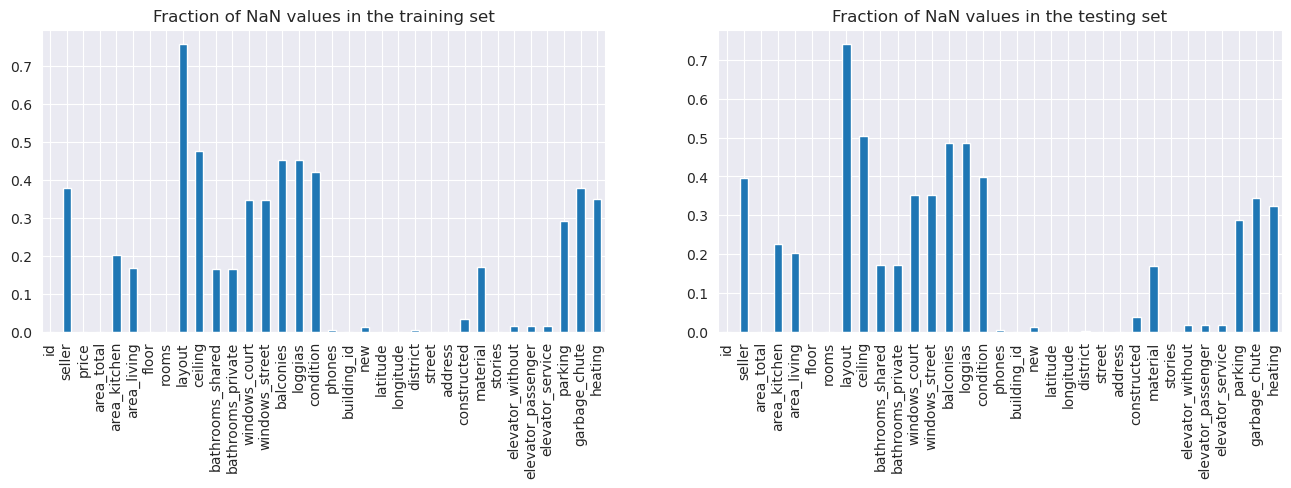

In [7]:
fig, (ax1, ax2) = plt.subplots(figsize=(16, 4), ncols=2, dpi=100)
print(f'Number of missing price entries in train data: {data_train.price.isna().sum()}')
print(f'Training set features with any missing value: {data_train.isna().any().sum()}/{data_train.shape[1]}')
print(f'Testing set features with any missing value: {data_test.isna().any().sum()}/{data_test.shape[1]}')
data_train.isna().mean().plot.bar(ax=ax1, title='Fraction of NaN values in the training set')
data_test.isna().mean().plot.bar(ax=ax2, title='Fraction of NaN values in the testing set');

As we see there are a lot of missing values in the 2 data sets, we are going to fill all of them but first of all we have to see the importance of every feature
We will plot all the valuess compared to price

# Relations in features
Now we are seing the relations between parameters and the importance they have with price feature

Text(0.5, 1.0, 'elevator_passenger')

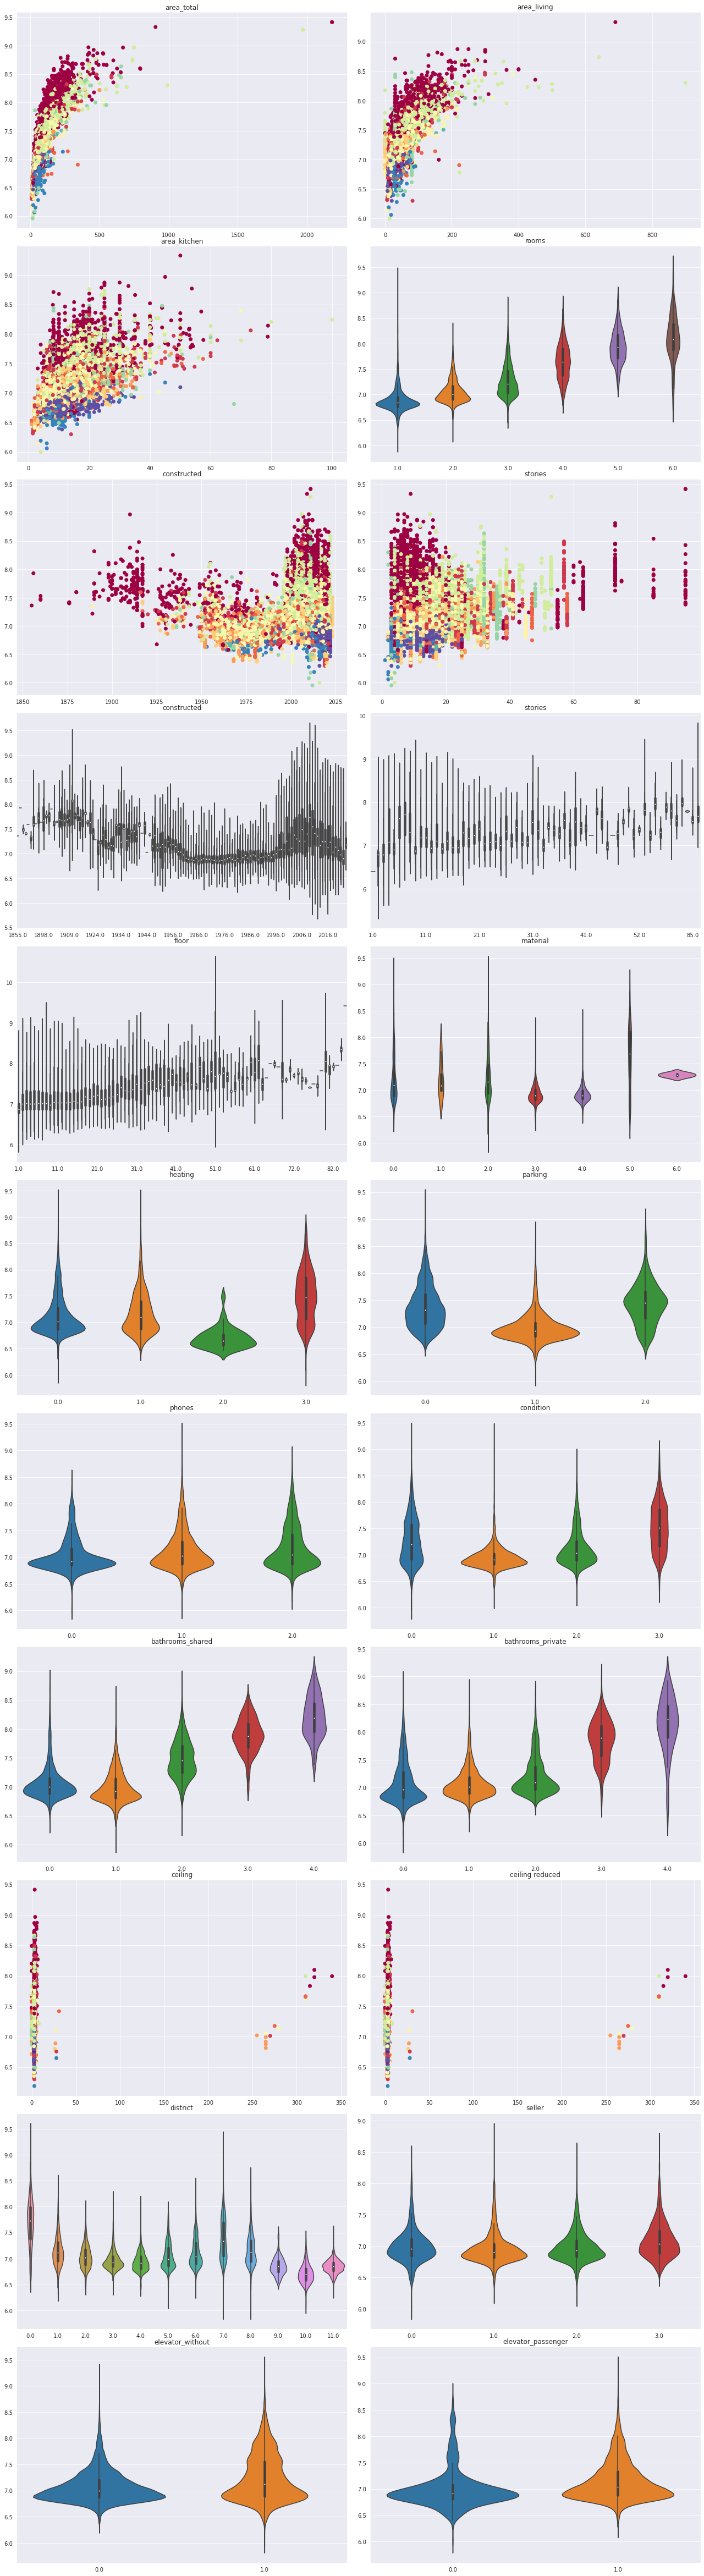

In [8]:
logprice = np.log10(data_train["price"])

rooms_data = data_train.copy()[["rooms","price"]]
rooms_data["price"] = logprice.copy()
floor_data = data_train.copy()[["floor","price"]]
floor_data["price"] = logprice.copy()
material_data = data_train.copy()[["material","price"]]
material_data["price"] = logprice.copy()
stories_data = data_train.copy()[["stories","price"]]
stories_data["price"] = logprice.copy()
constructed_data = data_train.copy()[["constructed","price"]]
constructed_data["price"] = logprice.copy()
heating_data = data_train.copy()[["heating","price"]]
heating_data["price"] = logprice.copy()
parking_data = data_train.copy()[["parking","price"]]
parking_data["price"] = logprice.copy()
phones_data = data_train.copy()[["phones","price"]]
phones_data["price"] = logprice.copy()
condition_data = data_train.copy()[["condition","price"]]
condition_data["price"] = logprice.copy()
bathrooms_shared_data = data_train.copy()[["bathrooms_shared","price"]]
bathrooms_shared_data["price"] = logprice.copy()
bathrooms_private_data = data_train.copy()[["bathrooms_private","price"]]
bathrooms_private_data["price"] = logprice.copy()
district_data = data_train.copy()[["district","price"]]
district_data["price"] = logprice.copy()
elevator_without_data = data_train.copy()[["elevator_without","price"]]
elevator_without_data["price"] = logprice.copy()
elevator_passenger_data = data_train.copy()[["elevator_passenger","price"]]
elevator_passenger_data["price"] = logprice.copy()
seller_data = data_train.copy()[["seller","price"]]
seller_data["price"] = logprice.copy()

ceiling_data = data_train.copy()
cei_logprice = np.log10(ceiling_data["price"])

fig, axs = plt.subplots(11, 2, figsize=(18,65))
fig.tight_layout()

axs[0, 0].scatter(data_train["area_total"], logprice, c=data_train["district"], cmap=plt.cm.Spectral)
axs[0, 0].set_title('area_total')

axs[0, 1].scatter(data_train["area_living"], logprice, c=data_train["district"], cmap=plt.cm.Spectral)
axs[0, 1].set_title('area_living')

axs[1, 0].scatter(data_train["area_kitchen"], logprice, c=data_train["district"], cmap=plt.cm.Spectral)
axs[1, 0].set_title('area_kitchen')

rooms_plot = sns.violinplot(x = rooms_data["rooms"], y = rooms_data["price"], data=rooms_data, ax=axs[1, 1])
rooms_plot.set(xlabel=None)
rooms_plot.set(ylabel=None)
axs[1, 1].set_title('rooms')

axs[2, 0].scatter(data_train["constructed"], logprice, c=data_train["district"], cmap=plt.cm.Spectral)
axs[2, 0].set_title('constructed')

axs[2, 1].scatter(data_train["stories"], logprice, c=data_train["district"], cmap=plt.cm.Spectral)
axs[2, 1].set_title('stories')

constructed_plot = sns.violinplot(x = constructed_data["constructed"], y = constructed_data["price"], data=constructed_data, ax=axs[3, 0])
constructed_plot.set(xlabel=None)
constructed_plot.set(ylabel=None)
for index, label in enumerate(constructed_plot.get_xticklabels()):
   if index % 10 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)
axs[3, 0].set_title('constructed')

stories_plot = sns.violinplot(x = stories_data["stories"], y = stories_data["price"], data=stories_data, ax=axs[3, 1])
stories_plot.set(xlabel=None)
stories_plot.set(ylabel=None)
for index, label in enumerate(stories_plot.get_xticklabels()):
   if index % 10 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)
axs[3, 1].set_title('stories')

floor_plot = sns.violinplot(x = floor_data["floor"], y = floor_data["price"], data=floor_data, ax=axs[4, 0])
floor_plot.set(xlabel=None)
floor_plot.set(ylabel=None)
for index, label in enumerate(floor_plot.get_xticklabels()):
   if index % 10 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)
axs[4, 0].set_title('floor')

material_plot = sns.violinplot(x = material_data["material"], y = material_data["price"], data=material_data, ax=axs[4, 1])
material_plot.set(xlabel=None)
material_plot.set(ylabel=None)
axs[4, 1].set_title('material')

heating_plot = sns.violinplot(x = heating_data["heating"], y = heating_data["price"], data=heating_data, ax=axs[5, 0])
heating_plot.set(xlabel=None)
heating_plot.set(ylabel=None)
axs[5, 0].set_title('heating')

parking_plot = sns.violinplot(x = parking_data["parking"], y = parking_data["price"], data=parking_data, ax=axs[5, 1])
parking_plot.set(xlabel=None)
parking_plot.set(ylabel=None)
axs[5, 1].set_title('parking')

phones_plot = sns.violinplot(x = phones_data["phones"], y = phones_data["price"], data=phones_data, ax=axs[6, 0])
phones_plot.set(xlabel=None)
phones_plot.set(ylabel=None)
axs[6, 0].set_title('phones')

condition_plot = sns.violinplot(x = condition_data["condition"], y = condition_data["price"], data=condition_data, ax=axs[6, 1])
condition_plot.set(xlabel=None)
condition_plot.set(ylabel=None)
axs[6, 1].set_title('condition')

bathrooms_shared_plot = sns.violinplot(x = bathrooms_shared_data["bathrooms_shared"], y = bathrooms_shared_data["price"], data=bathrooms_shared_data, ax=axs[7, 0])
bathrooms_shared_plot.set(xlabel=None)
bathrooms_shared_plot.set(ylabel=None)
axs[7, 0].set_title('bathrooms_shared')

bathrooms_private_plot = sns.violinplot(x = bathrooms_private_data["bathrooms_private"], y = bathrooms_private_data["price"], data=bathrooms_private_data, ax=axs[7, 1])
bathrooms_private_plot.set(xlabel=None)
bathrooms_private_plot.set(ylabel=None)
axs[7, 1].set_title('bathrooms_private')

axs[8, 0].scatter(data_train["ceiling"], logprice, c=data_train["district"], cmap=plt.cm.Spectral)
axs[8, 0].set_title('ceiling')

axs[8, 1].scatter(ceiling_data["ceiling"], cei_logprice, c=ceiling_data["district"], cmap=plt.cm.Spectral)
axs[8, 1].set_title('ceiling reduced')

district_plot = sns.violinplot(x = district_data["district"], y = district_data["price"], data=district_data, ax=axs[9, 0])
district_plot.set(xlabel=None)
district_plot.set(ylabel=None)
axs[9, 0].set_title('district')

seller_plot = sns.violinplot(x = seller_data["seller"], y = seller_data["price"], data=seller_data, ax=axs[9, 1])
seller_plot.set(xlabel=None)
seller_plot.set(ylabel=None)
axs[9, 1].set_title('seller')

elevator_without_plot = sns.violinplot(x = elevator_without_data["elevator_without"], y = elevator_without_data["price"], data=elevator_without_data, ax=axs[10, 0])
elevator_without_plot.set(xlabel=None)
elevator_without_plot.set(ylabel=None)
axs[10, 0].set_title('elevator_without')

elevator_passenger_plot = sns.violinplot(x = elevator_passenger_data["elevator_passenger"], y = elevator_passenger_data["price"], data=elevator_passenger_data, ax=axs[10, 1])
elevator_passenger_plot.set(xlabel=None)
elevator_passenger_plot.set(ylabel=None)
axs[10, 1].set_title('elevator_passenger')



As we can see there are some features that can be fixed in order to get more information about the price

## Correlation
Spearman correlation is better to work with in this case because it picks up relationships between variables even when they are nonlinear. area_total is main criterion in establishing house price.

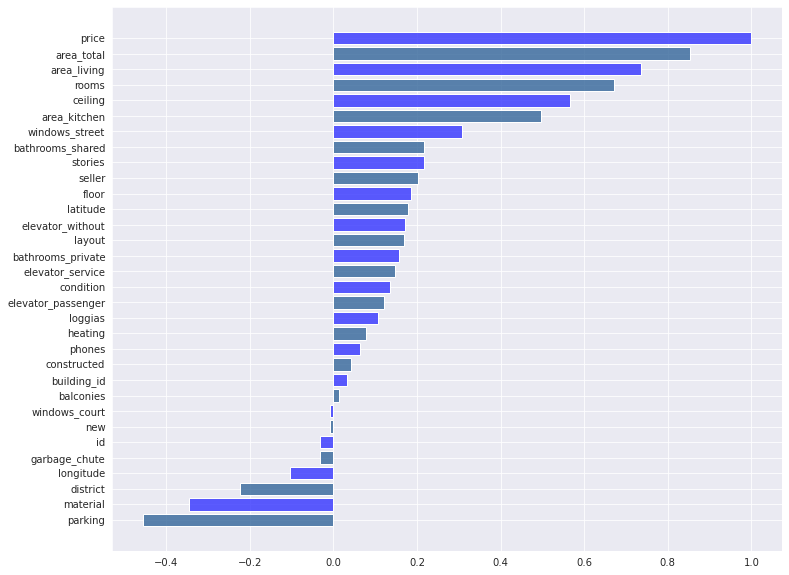

In [9]:
d = data_train.copy()
c = d.corrwith(np.log10(d['price']), method = 'spearman')
c = c.sort_values()

fig, ax = plt.subplots(figsize=(12,10))
ax = plt.barh(c.index,c,color=[(0.2, 0.4, 0.6, 0.8),(0.2, 0.2, 1.0, 0.8)])

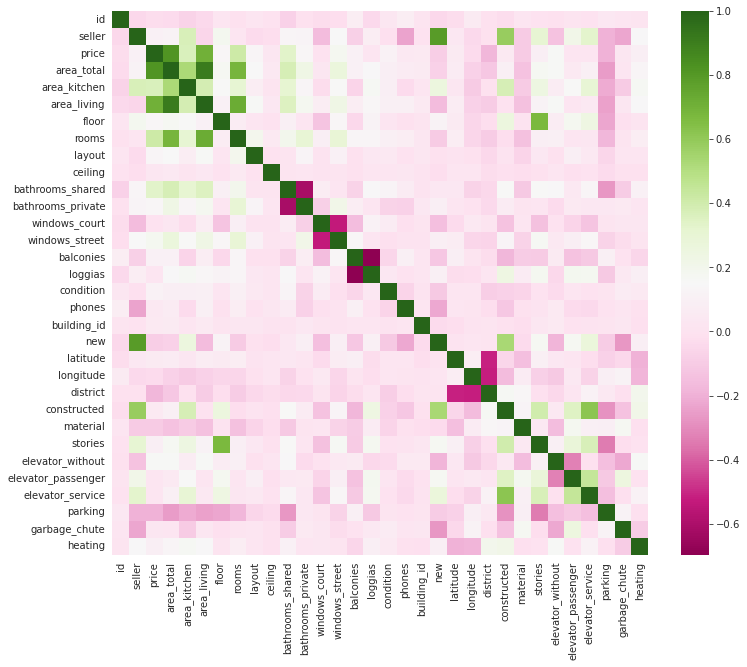

In [10]:
fig, ax = plt.subplots(figsize=(12,10))
corr = data_train.corr()
x=sns.heatmap(corr,ax=ax,cmap='PiYG')

## Anova 
Here is quick estimation of influence of categorical variable on SalePrice. For each variable SalePrices are partitioned to distinct sets based on category values. Then check with ANOVA test if sets have similar distributions. If variable has minor impact then set means should be equal. Decreasing pval is sign of increasing diversity in partitions.

/tmp/ipykernel_31473/3166365836.py:19: RuntimeWarning: divide by zero encountered in true_divide
  anv['disparity'] = np.log(1./anv['pval'].values)


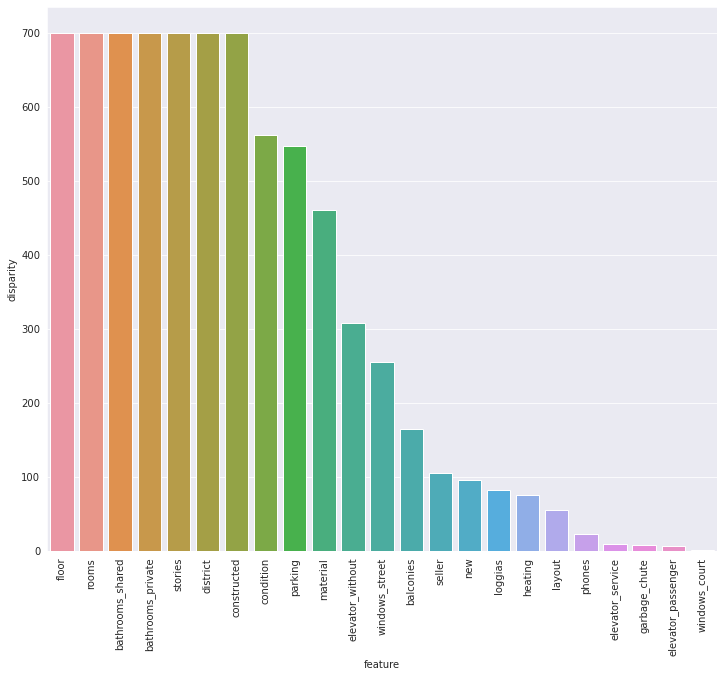

In [11]:
import scipy.stats as stats

qualitative = data_train.copy()[["price","seller","floor","rooms","layout","bathrooms_shared","bathrooms_private","windows_court","windows_street","balconies","loggias","condition","phones","new","district","constructed","material","stories","elevator_without","elevator_passenger","elevator_service","parking","garbage_chute","heating"]]
quali_features = [f for f in qualitative.columns if f != "price"]

anv = pd.DataFrame()
anv['feature'] = quali_features
pvals = []
for c in quali_features:
    samples = []
    for cls in qualitative[c].unique():
        s = qualitative[qualitative[c] == cls]['price'].values
        if len(s) != 0 :
            samples.append(s)
    pval = stats.f_oneway(*samples)[1]
    pvals.append(pval)
anv['pval'] = pvals

anv['disparity'] = np.log(1./anv['pval'].values)
for ind, row in anv.iterrows():
    if row['disparity'] > 600.0:
        anv['disparity'][ind] = 700.0
        
fig, ax = plt.subplots(figsize=(12,10))
sns.barplot(data=anv.sort_values('pval'), x='feature', y='disparity', ax=ax)
x=plt.xticks(rotation=90)

So if we have a look at the correlation graph as we can see area_total is the best feature for the price and then we have area_living, rooms and ceiling, so we will take a carefull look on how we fill the missing values
On the other hand if we have a look at the anova test first we have floor, rooms, and bathrooms.


## Filling the Missing Values 
So we are going to fill all the missing values firstly.

In [12]:
data_train_filled = data_train.copy()
data_test_filled = data_test.copy()

data_train_filled['phones'] = data_train_filled['phones'].fillna(0)
data_train_filled['seller'] = data_train_filled['seller'].fillna(4)
data_train_filled['layout'] = data_train_filled['layout'].fillna(3)
data_train_filled['parking'] = data_train_filled['parking'].fillna(3)
data_train_filled['heating'] = data_train_filled['heating'].fillna(4)
data_train_filled['elevator_service'] = data_train_filled['elevator_service'].fillna(2)
data_train_filled['elevator_passenger'] = data_train_filled['elevator_passenger'].fillna(2)
data_train_filled['elevator_without'] = data_train_filled['elevator_without'].fillna(2)
data_train_filled['garbage_chute'] = data_train_filled['garbage_chute'].fillna(2)
data_train_filled['windows_street'] = data_train_filled['windows_street'].fillna(2)
data_train_filled['windows_court'] = data_train_filled['windows_court'].fillna(2)
data_train_filled['balconies'] = data_train_filled['balconies'].fillna(0)
data_train_filled['loggias'] = data_train_filled['loggias'].fillna(0)
data_train_filled['condition'] = data_train_filled['condition'].fillna(5)

data_test_filled['phones'] = data_test_filled['phones'].fillna(0)
data_test_filled['seller'] = data_test_filled['seller'].fillna(4)
data_test_filled['layout'] = data_test_filled['layout'].fillna(3)
data_test_filled['parking'] = data_test_filled['parking'].fillna(3)
data_test_filled['heating'] = data_test_filled['heating'].fillna(4)
data_test_filled['elevator_service'] = data_test_filled['elevator_service'].fillna(2)
data_test_filled['elevator_passenger'] = data_test_filled['elevator_passenger'].fillna(2)
data_test_filled['elevator_without'] = data_test_filled['elevator_without'].fillna(2)
data_test_filled['garbage_chute'] = data_test_filled['garbage_chute'].fillna(2)
data_test_filled['windows_street'] = data_test_filled['windows_street'].fillna(2)
data_test_filled['windows_court'] = data_test_filled['windows_court'].fillna(2)
data_test_filled['balconies'] = data_test_filled['balconies'].fillna(0)
data_test_filled['loggias'] = data_test_filled['loggias'].fillna(0)
data_test_filled['condition'] = data_test_filled['condition'].fillna(5)

First of all we have fixed those values that weren't important at all or they didn't had a real relation to anyother feature in order to get and aproximation for the missing values.


-These are:

    -Phones: Filled with 0 as there isn't phones
    -Seller: Filled with 4 as there is no value
    -Layout: Filled with 3 as there is no value
    -Parking: Filled with 3 as there isn't a parking
    -Heating: Filled with 4 as there is no value
    -Elevator_service: Filled with 2 as there is no value
    -Elevator_passenger: Filled with 2 as there is no value
    -Elevator_without: Filled with 2 as there is no value
    -Garbage_chute: Filled with 2 as there is no value
    -Windows_street: Filled with 2 as there is no value
    -Windows_court: Filled with 2 as there is no value
    -Loggias:Filled with 0 as there is no loggias
    -Condition: Filled with 5 as there is no value

## 2 Missing Values at Latitude and Longitude in TestSet

In [13]:
street=[]
for i in range(len(data_test_filled)):
    if(data_test_filled.isna()['longitude'][i]):
        street.append(data_test['street'][i])
long=0
latitude=0
total=0
for i in range(len(data_test_filled)):
    for j in range(len(street)):
        if(data_test_filled['street'][i] == street[j]):
            if(data_test_filled.isna()['longitude'][i] == False):
                long=+data_test_filled['longitude'][i]
                latitude=+ data_test_filled['latitude'][i]
                total=+1
long=long/total
latitude= latitude/total

for i in range(len(data_test_filled)):                
    if(long!=0):
        if(data_test_filled.isna()['longitude'][i]):
            data_test_filled['longitude'][i] = long
            data_test_filled['latitude'][i] = latitude


## Area_living 
First of all we have to change some of the wrong values as you can't have an area living lower than 1m

In [14]:
# Changing wrong values 
for idx, val in enumerate(data_train_filled['area_living']):
     if val < 1:
        data_train_filled['area_living'][idx] = np.nan    
for idx, val in enumerate(data_test_filled['area_living']):
     if val < 1:
        data_test_filled['area_living'][idx] = np.nan

   

### Changing the areas
We will use the log10 of the areas as they give more information and it's easier to work with them here we can see how our input changes if we use the log:

<AxesSubplot:xlabel='log10(area_kitchen)', ylabel='Count'>

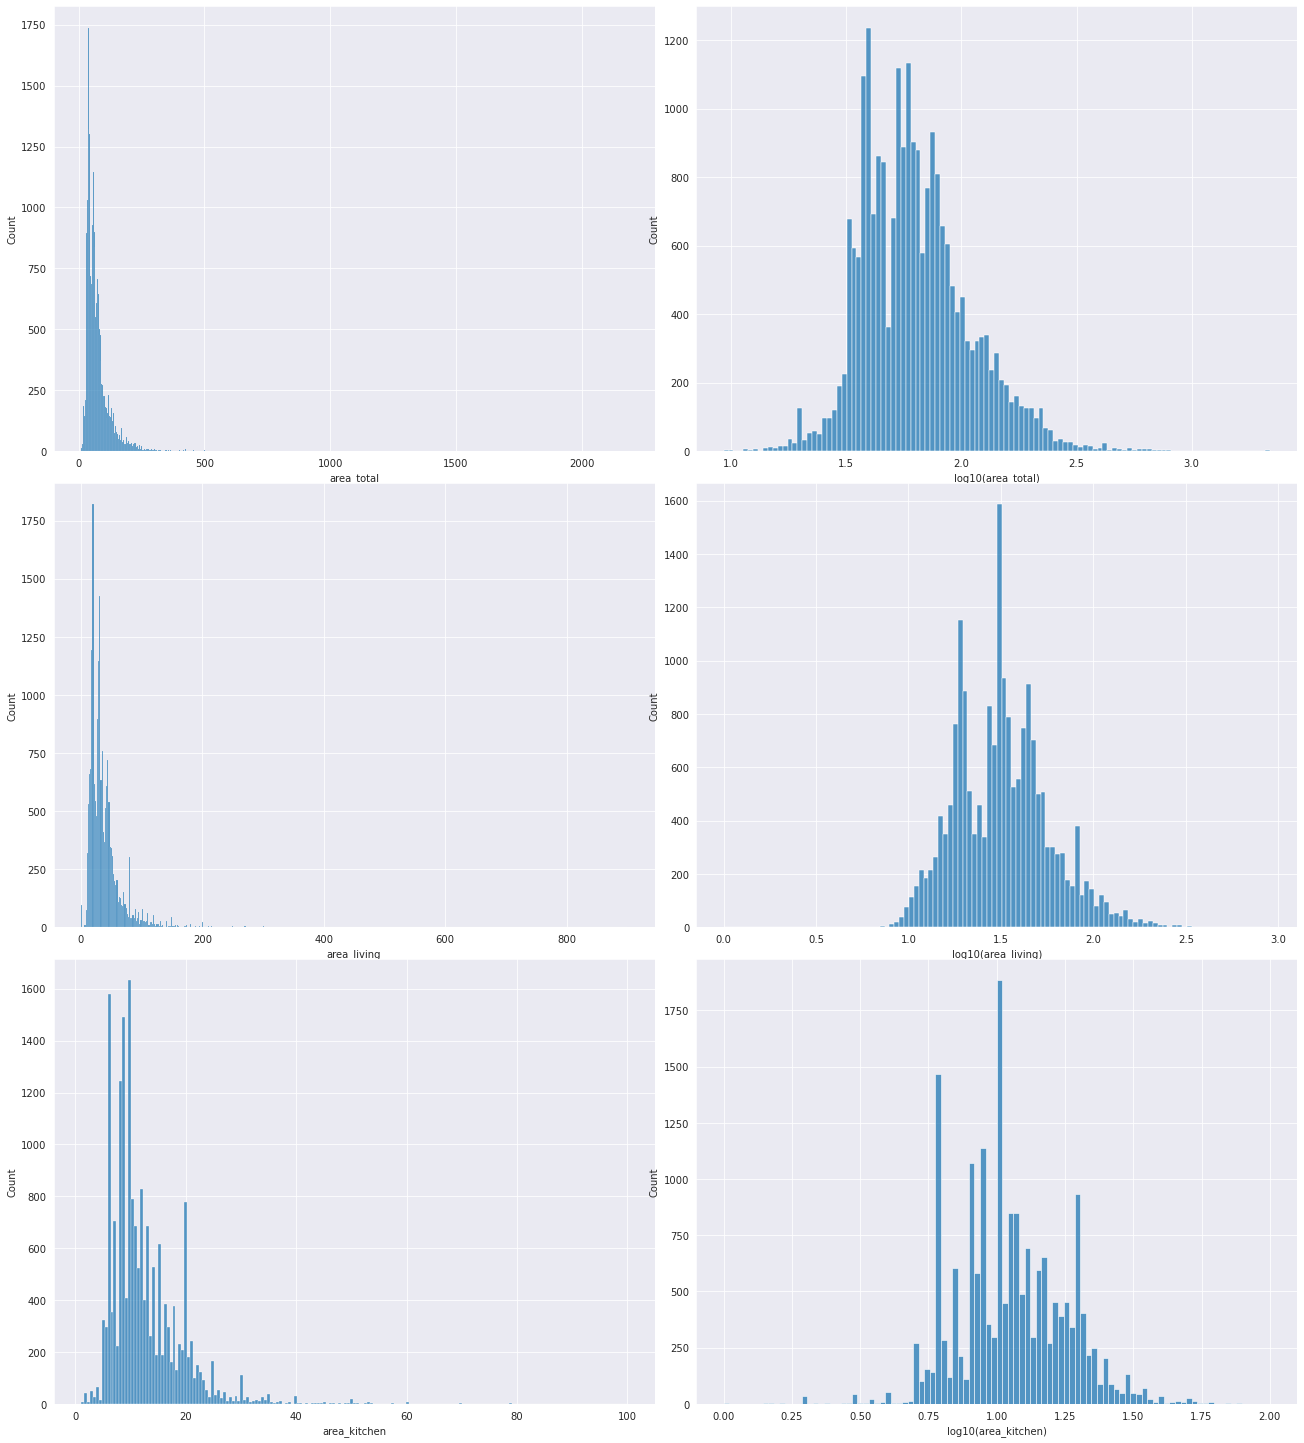

In [15]:

data_train_filled['area_total'] = np.log10(data_train_filled['area_total'])
data_train_filled['area_living'] = np.log10(data_train_filled['area_living'])
data_train_filled['area_kitchen'] = np.log10(data_train_filled['area_kitchen'])

data_test_filled['area_total'] = np.log10(data_test_filled['area_total'])
data_test_filled['area_living'] = np.log10(data_test_filled['area_living'])
data_test_filled['area_kitchen'] = np.log10(data_test_filled['area_kitchen'])

fig, axs = plt.subplots(3, 2, figsize=(18,20))
fig.tight_layout()

data_train_base = data_train.copy()
data_train=data_train_filled
sns.histplot(data_train_base.area_total.rename('area_total'), ax=axs[0,0])
sns.histplot(data_train.area_total.rename('log10(area_total)'), ax=axs[0,1])
sns.histplot(data_train_base.area_living.rename('area_living'), ax=axs[1,0])
sns.histplot(data_train.area_living.rename('log10(area_living)'), ax=axs[1,1])
sns.histplot(data_train_base.area_kitchen.rename('area_kitchen'), ax=axs[2,0])
sns.histplot(data_train.area_kitchen.rename('log10(area_kitchen)'), ax=axs[2,1])


So now we will fill those missing values with RandomForestRegressor

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
rfrmodel = RandomForestRegressor()
rfcmodel = RandomForestClassifier()

sub_data_train = data_train_filled[pd.isnull(data_train_filled['area_living']) == False]
sub_data_train_miss = data_train_filled[pd.isnull(data_train_filled['area_living'])]
sub_data_test = data_test_filled[pd.isnull(data_test_filled['area_living']) == False]
sub_data_test_miss = data_test_filled[pd.isnull(data_test_filled['area_living'])]

rfrmodel = RandomForestRegressor(n_estimators = 800, max_features = 'sqrt', max_depth = 40, min_samples_split = 5, min_samples_leaf = 1, bootstrap = True)

features = ['latitude','longitude','area_total']


In [17]:
# Creating the model
rfrmodel.fit(sub_data_train[features],sub_data_train['area_living'])

# Generating values
generated_values = rfrmodel.predict(X = sub_data_train_miss[features])
sub_data_train_miss['area_living'] = generated_values.copy()
generated_values = rfrmodel.predict(X = sub_data_test_miss[features])
sub_data_test_miss['area_living'] = generated_values.copy()

data_train_filled = sub_data_train.append(sub_data_train_miss)
data_train_filled.sort_values(by=['id'],inplace=True)
data_test_filled = sub_data_test.append(sub_data_test_miss)
data_test_filled.sort_values(by=['id'],inplace=True)

## Area Kitchen
For area Kitchen we will use a randomForest using the features latitude longitude and area_total

In [18]:
sub_data_train = data_train_filled[pd.isnull(data_train_filled['area_kitchen']) == False]
sub_data_train_miss = data_train_filled[pd.isnull(data_train_filled['area_kitchen'])]
sub_data_test = data_test_filled[pd.isnull(data_test_filled['area_kitchen']) == False]
sub_data_test_miss = data_test_filled[pd.isnull(data_test_filled['area_kitchen'])]

rfrmodel = RandomForestRegressor(n_estimators = 1000, max_features = 'sqrt', max_depth = 20, min_samples_split = 2, min_samples_leaf = 1, bootstrap = True)

features = ['latitude','longitude','area_total']

# Creating the model
rfrmodel.fit(sub_data_train[features],sub_data_train['area_kitchen'])

# Generating values
generated_values = rfrmodel.predict(X = sub_data_train_miss[features])
sub_data_train_miss['area_kitchen'] = generated_values.copy()
generated_values = rfrmodel.predict(X = sub_data_test_miss[features])
sub_data_test_miss['area_kitchen'] = generated_values.copy()

data_train_filled = sub_data_train.append(sub_data_train_miss)
data_train_filled.sort_values(by=['id'],inplace=True)
data_test_filled = sub_data_test.append(sub_data_test_miss)
data_test_filled.sort_values(by=['id'],inplace=True)

## District
For district we will use randomForest using the features latitude and longitude

In [19]:
print(data_test_filled.isnull().sum())

id                       0
seller                   0
area_total               0
area_kitchen             0
area_living              0
floor                    0
rooms                    0
layout                   0
ceiling               5018
bathrooms_shared      1717
bathrooms_private     1717
windows_court            0
windows_street           0
balconies                0
loggias                  0
condition                0
phones                   0
building_id              0
new                    109
latitude                 0
longitude                0
district                25
street                   0
address                  0
constructed            374
material              1671
stories                  0
elevator_without         0
elevator_passenger       0
elevator_service         0
parking                  0
garbage_chute            0
heating                  0
dtype: int64


In [20]:
sub_data_train = data_train_filled[pd.isnull(data_train_filled['district']) == False]
sub_data_train_miss = data_train_filled[pd.isnull(data_train_filled['district'])]
sub_data_test = data_test_filled[pd.isnull(data_test_filled['district']) == False]
sub_data_test_miss = data_test_filled[pd.isnull(data_test_filled['district'])]

# Here we don't care about the parameters because latitude and longitude give the right district with basic parameters

features = ['latitude','longitude']

# Creating the model
rfcmodel.fit(sub_data_train[features],sub_data_train['district'])

# Generating values
generated_values = rfcmodel.predict(X = sub_data_train_miss[features])
sub_data_train_miss['district'] = generated_values.copy()
generated_values = rfcmodel.predict(X = sub_data_test_miss[features])
sub_data_test_miss['district'] = generated_values.copy()

data_train_filled = sub_data_train.append(sub_data_train_miss)
data_train_filled.sort_values(by=['id'],inplace=True)
data_test_filled = sub_data_test.append(sub_data_test_miss)
data_test_filled.sort_values(by=['id'],inplace=True)

## Material
For material we will use randomForest using the features latitude, longitude and stories

In [21]:
sub_data_train = data_train_filled[pd.isnull(data_train_filled['material']) == False]
sub_data_train_miss = data_train_filled[pd.isnull(data_train_filled['material'])]
sub_data_test = data_test_filled[pd.isnull(data_test_filled['material']) == False]
sub_data_test_miss = data_test_filled[pd.isnull(data_test_filled['material'])]

rfcmodel = RandomForestClassifier(n_estimators = 1400, max_features = 'sqrt', max_depth = 80, min_samples_split = 5, min_samples_leaf = 1, bootstrap = False)

features = ['latitude','longitude','stories']

# Creating the model
rfcmodel.fit(sub_data_train[features],sub_data_train['material'])

# Generating values
generated_values = rfcmodel.predict(X = sub_data_train_miss[features])
sub_data_train_miss['material'] = generated_values.copy()
generated_values = rfcmodel.predict(X = sub_data_test_miss[features])
sub_data_test_miss['material'] = generated_values.copy()

data_train_filled = sub_data_train.append(sub_data_train_miss)
data_train_filled.sort_values(by=['id'],inplace=True)
data_test_filled = sub_data_test.append(sub_data_test_miss)
data_test_filled.sort_values(by=['id'],inplace=True)

## Constructed
### Using 'new'
So as constructed have a relation with new we will use it for setting and aproximate year.
First of all we look if the building has not the constructed value but it has the new value. So that will mean that the building is new so we can get a random integer between 2019 and the max_value at constructed

Here we can see a plot where we can see the years and when is it new

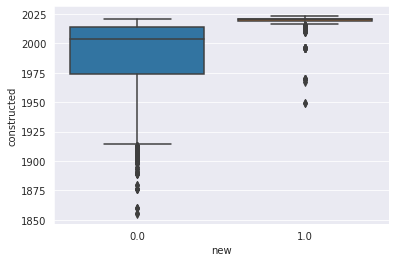

In [22]:
#Fix the constructed data
data_train['constructed'].max()
data_train['new']
x=sns.boxplot(x='new',y='constructed',data=data_train)



In [23]:
constructed_train= data_train.copy()[['new','constructed']]
max_value = max(constructed_train['constructed'])

for i in range(len(constructed_train)):
    if(np.isnan(constructed_train['constructed'][i]) == True):
        if np.isnan(constructed_train['new'][i]) != True :
            if constructed_train['new'][i] == 1:
                constructed_train['constructed'][i] = np.random.randint(low=2019,high=max_value,dtype=int)

data_train_filled['constructed'] = constructed_train['constructed'].copy()

In [24]:
constructed_test= data_train.copy()[['new','constructed']]
max_value = max(constructed_test['constructed'])

for i in range(len(constructed_test)):
    if(np.isnan(constructed_test['constructed'][i]) == True):
        if np.isnan(constructed_test['new'][i]) != True :
            if constructed_test['new'][i] == 1:
                constructed_test['constructed'][i] = np.random.randint(low=2019,high=max_value,dtype=int)

data_test_filled['constructed'] = constructed_test['constructed'].copy()

As we couldn't fill all the missing values we will do random forest with the rest of the missing Values. We will use latitude and longitude to get those missing values:

In [25]:
sub_data_train = data_train_filled[pd.isnull(data_train_filled['constructed']) == False]
sub_data_train_miss = data_train_filled[pd.isnull(data_train_filled['constructed'])]
sub_data_test = data_test_filled[pd.isnull(data_test_filled['constructed']) == False]
sub_data_test_miss = data_test_filled[pd.isnull(data_test_filled['constructed'])]

rfcmodel = RandomForestClassifier()

features = ['latitude','longitude']

# Creating the model
rfcmodel.fit(sub_data_train[features],sub_data_train['constructed'])

# Generating values
generated_values = rfcmodel.predict(X = sub_data_train_miss[features])
sub_data_train_miss['constructed'] = generated_values.copy()
generated_values = rfcmodel.predict(X = sub_data_test_miss[features])
sub_data_test_miss['constructed'] = generated_values.copy()

data_train_filled = sub_data_train.append(sub_data_train_miss)
data_train_filled.sort_values(by=['id'],inplace=True)
data_test_filled = sub_data_test.append(sub_data_test_miss)
data_test_filled.sort_values(by=['id'],inplace=True)

## New
For new we will use randomForest using the feature Constructed

In [26]:
sub_data_train = data_train_filled[pd.isnull(data_train_filled['new']) == False]
sub_data_train_miss = data_train_filled[pd.isnull(data_train_filled['new'])]
sub_data_test = data_test_filled[pd.isnull(data_test_filled['new']) == False]
sub_data_test_miss = data_test_filled[pd.isnull(data_test_filled['new'])]

features = ['constructed']

# Creating the model
rfcmodel.fit(sub_data_train[features],sub_data_train['new'])

# Generating values
generated_values = rfcmodel.predict(X = sub_data_train_miss[features])
sub_data_train_miss['new'] = generated_values.copy()
generated_values = rfcmodel.predict(X = sub_data_test_miss[features])
sub_data_test_miss['new'] = generated_values.copy()

data_train_filled = sub_data_train.append(sub_data_train_miss)
data_train_filled.sort_values(by=['id'],inplace=True)
data_test_filled = sub_data_test.append(sub_data_test_miss)
data_test_filled.sort_values(by=['id'],inplace=True)

## Ceiling
#### Changing wrong values 
So there can't be any celing higher than 100 m so we decrease those values into a more normal measures.
Then if we find some ceilings that are lower than 1m we will just pust them as nan values in order to fill them later.

In [27]:
# Changing wrong values 
for index in range(len(data_train_filled['ceiling'])):
    if data_train_filled['ceiling'][index] > 100:
        tmp=data_train_filled.copy()['ceiling'][index]/100
        data_train_filled['ceiling'][index] = tmp
    if data_train_filled['ceiling'][index] > 15:
        tmp=data_train_filled.copy()['ceiling'][index]/10
        data_train_filled['ceiling'][index] = tmp
    if data_train_filled['ceiling'][index] < 1:
        tmp=np.nan
        data_train_filled['ceiling'][index] = tmp

In [28]:
# Changing wrong values 
for index in range(len(data_test_filled['ceiling'])):
    if data_test_filled['ceiling'][index] > 100:
        tmp=data_test_filled.copy()['ceiling'][index]/100
        data_test_filled['ceiling'][index] = tmp
    if data_test_filled['ceiling'][index] > 15:
        tmp=data_test_filled.copy()['ceiling'][index]/10
        data_test_filled['ceiling'][index] = tmp
    if data_test_filled['ceiling'][index] < 1:
        tmp=np.nan
        data_test_filled['ceiling'][index] = tmp

For ceiling we will also use the log as we can see better the info as you can see in the plot

In [29]:
ceiling_base=data_train_filled.copy()['ceiling']
data_train_filled['ceiling'] = np.log10(data_train_filled['ceiling'])
data_test_filled['ceiling'] = np.log10(data_train_filled['ceiling'])

<AxesSubplot:xlabel='log10(ceiling)', ylabel='Count'>

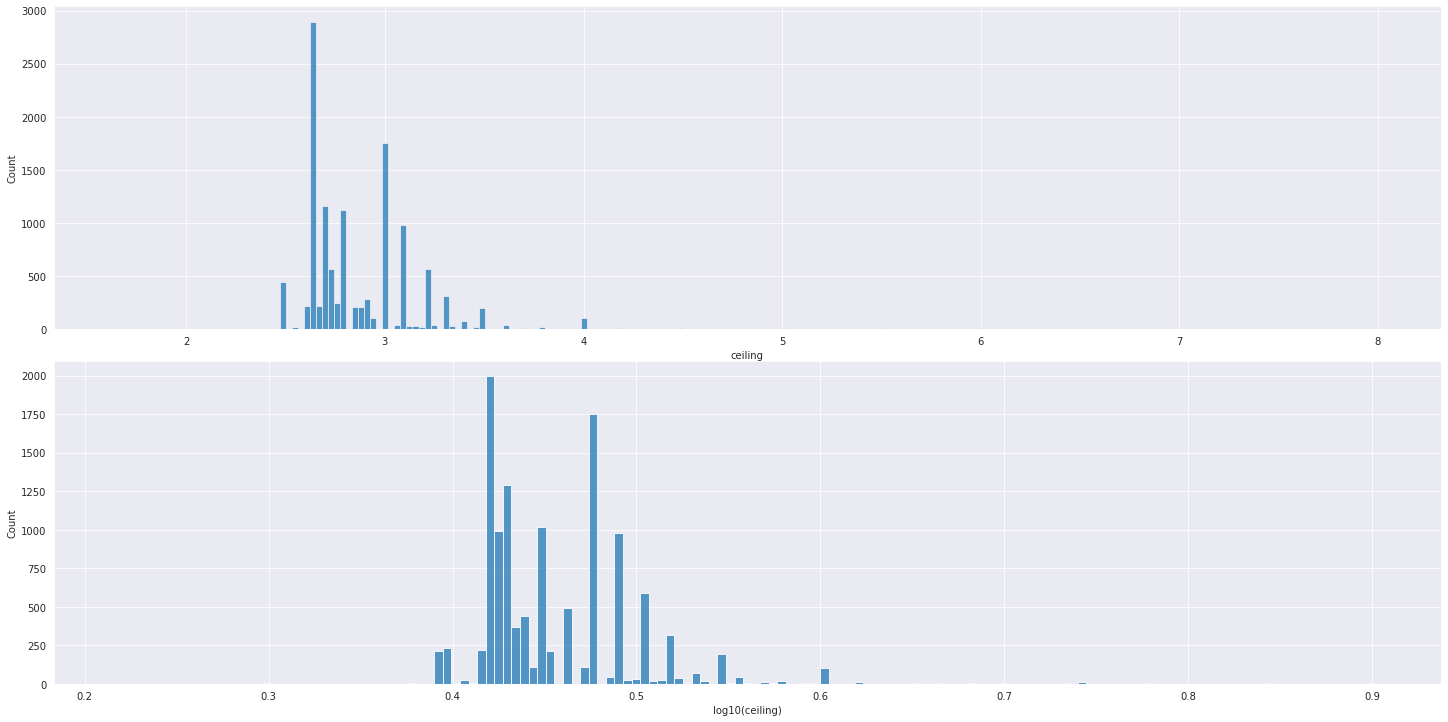

In [30]:
fig, axs = plt.subplots(2, figsize=(20,10))
fig.tight_layout()

sns.histplot(ceiling_base.rename('ceiling'), ax=axs[0])
sns.histplot(data_train_filled.ceiling.rename('log10(ceiling)'), ax=axs[1])


#### Now we will fill those missing values with randomForest
For ceiling we will use the features latitude, longitude and constructed

In [31]:
sub_data_train = data_train_filled[pd.isnull(data_train_filled['ceiling']) == False]
sub_data_train_miss = data_train_filled[pd.isnull(data_train_filled['ceiling'])]
sub_data_test = data_test_filled[pd.isnull(data_test_filled['ceiling']) == False]
sub_data_test_miss = data_test_filled[pd.isnull(data_test_filled['ceiling'])]

rfrmodel = RandomForestRegressor()

features = ['latitude','longitude','constructed']

# Creating the model
rfrmodel.fit(sub_data_train[features],sub_data_train['ceiling'])

# Generating values
generated_values = rfrmodel.predict(X = sub_data_train_miss[features])
sub_data_train_miss['ceiling'] = generated_values.copy()
generated_values = rfrmodel.predict(X = sub_data_test_miss[features])
sub_data_test_miss['ceiling'] = generated_values.copy()

data_train_filled = sub_data_train.append(sub_data_train_miss)
data_train_filled.sort_values(by=['id'],inplace=True)
data_test_filled = sub_data_test.append(sub_data_test_miss)
data_test_filled.sort_values(by=['id'],inplace=True)

## Bathrooms Shared
For the bathrooms shared we will use randomForest using the features longitude latitude, area_total and rooms

In [32]:
sub_data_train = data_train_filled[pd.isnull(data_train_filled['bathrooms_shared']) == False]
sub_data_train_miss = data_train_filled[pd.isnull(data_train_filled['bathrooms_shared'])]
sub_data_test = data_test_filled[pd.isnull(data_test_filled['bathrooms_shared']) == False]
sub_data_test_miss = data_test_filled[pd.isnull(data_test_filled['bathrooms_shared'])]

features = ['latitude','longitude','area_total','rooms']

# Creating the model
rfcmodel.fit(sub_data_train[features],sub_data_train['bathrooms_shared'])

# Generating values
generated_values = rfcmodel.predict(X = sub_data_train_miss[features])
sub_data_train_miss['bathrooms_shared'] = generated_values.copy()
generated_values = rfcmodel.predict(X = sub_data_test_miss[features])
sub_data_test_miss['bathrooms_shared'] = generated_values.copy()

data_train_filled = sub_data_train.append(sub_data_train_miss)
data_train_filled.sort_values(by=['id'],inplace=True)
data_test_filled = sub_data_test.append(sub_data_test_miss)
data_test_filled.sort_values(by=['id'],inplace=True)

## Bathrooms Private
For the bathrooms shared we will use randomForest using the features longitude, latitude, area_total and rooms

In [33]:
sub_data_train = data_train_filled[pd.isnull(data_train_filled['bathrooms_private']) == False]
sub_data_train_miss = data_train_filled[pd.isnull(data_train_filled['bathrooms_private'])]
sub_data_test = data_test_filled[pd.isnull(data_test_filled['bathrooms_private']) == False]
sub_data_test_miss = data_test_filled[pd.isnull(data_test_filled['bathrooms_private'])]

features = ['latitude','longitude','area_total','rooms']

# Creating the model
rfcmodel.fit(sub_data_train[features],sub_data_train['bathrooms_private'])

# Generating values
generated_values = rfcmodel.predict(X = sub_data_train_miss[features])
sub_data_train_miss['bathrooms_private'] = generated_values.copy()
generated_values = rfcmodel.predict(X = sub_data_test_miss[features])
sub_data_test_miss['bathrooms_private'] = generated_values.copy()

data_train_filled = sub_data_train.append(sub_data_train_miss)
data_train_filled.sort_values(by=['id'],inplace=True)
data_test_filled = sub_data_test.append(sub_data_test_miss)
data_test_filled.sort_values(by=['id'],inplace=True)

# Applying the changes to datasets
So now we will get all the subsets we made into the data_train.

We will also have 2 more dataFrames that will contain the same values but without the log calculation inside.
So that we will reverse the operation in those features that we did the log10 into the values.

In [34]:
data_train = data_train_filled.copy()
data_test = data_test_filled.copy()

data_train_base = data_train.copy()
data_train_base['area_total'] = 10**data_train_base['area_total']
data_train_base['area_kitchen'] = 10**data_train_base['area_kitchen']
data_train_base['area_living'] = 10**data_train_base['area_living']
data_train_base['ceiling'] = 10**data_train_base['ceiling']

data_test_base = data_test.copy()
data_test_base['area_total'] = 10**data_test_base['area_total']
data_test_base['area_kitchen'] = 10**data_test_base['area_kitchen']
data_test_base['area_living'] = 10**data_test_base['area_living']
data_test_base['ceiling'] = 10**data_test_base['ceiling']

#### Looking if we have any missing value:

Training set features with any missing value: 0/34
Testing set features with any missing value: 0/33


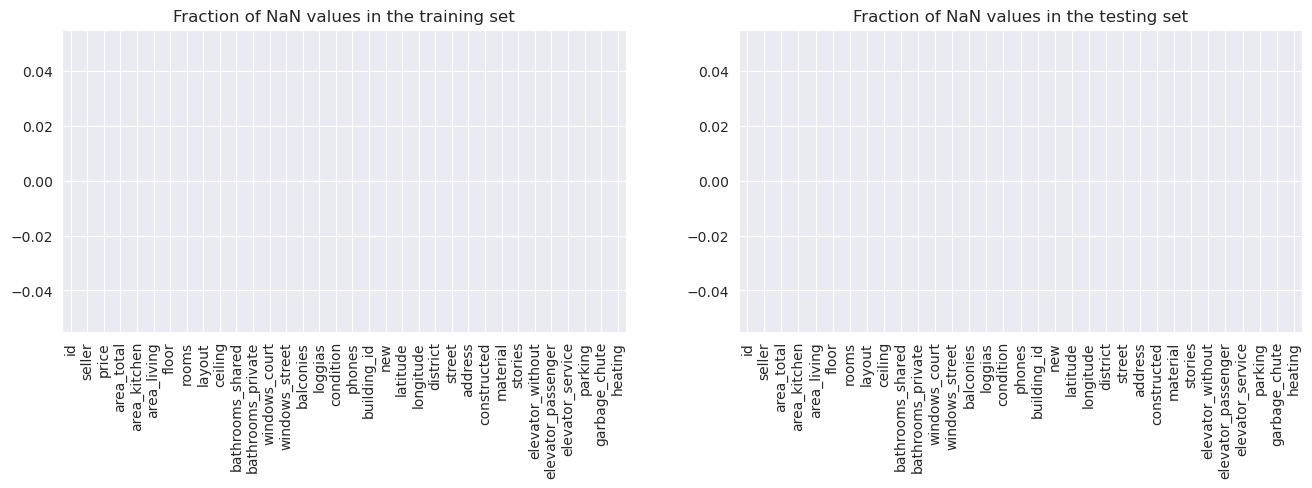

In [35]:
fig, (ax1, ax2) = plt.subplots(figsize=(16, 4), ncols=2, dpi=100)
print(f'Training set features with any missing value: {data_train.isna().any().sum()}/{data_train.shape[1]}')
print(f'Testing set features with any missing value: {data_test.isna().any().sum()}/{data_test.shape[1]}')
data_train.isna().mean().plot.bar(ax=ax1, title='Fraction of NaN values in the training set')
data_test.isna().mean().plot.bar(ax=ax2, title='Fraction of NaN values in the testing set');

So now that we have filled all the missing values we can see if we can generate some more features in order to get more information or 
# New Features

## Bathrooms Total
So as we have the number of bathrooms shared and bathrooms private we can see how many bathrooms has an apartment


In [36]:
data_train['bathrooms_total']=data_train['bathrooms_shared']+data_train['bathrooms_private']
print(data_train['bathrooms_total'].describe())

data_test['bathrooms_total']=data_test['bathrooms_shared']+data_test['bathrooms_private']
print("\n",data_test['bathrooms_total'].describe())


count    23285.000000
mean         1.414043
std          0.693282
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          8.000000
Name: bathrooms_total, dtype: float64

 count    9937.000000
mean        1.391265
std         0.706591
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         8.000000
Name: bathrooms_total, dtype: float64


## Distance to the center:
As we can see in this plot all the prices have a connection of how far of the center they are so we will create a feature to determine the distance between the building and the center

In [37]:
def plot_map(data, ax=None, s=5, a=0.75, q_lo=0.0, q_hi=0.9, cmap='hot', column='price', title='Moscow apartment price by location'):
    data = data[['latitude', 'longitude', column]].sort_values(by=column, ascending=True)
    backdrop = plt.imread('data/moscow.png')
    backdrop = np.einsum('hwc, c -> hw', backdrop, [0, 1, 0, 0]) ** 2
    if ax is None:
        plt.figure(figsize=(12, 8), dpi=100)
        ax = plt.gca()
    discrete = data[column].nunique() <= 20
    if not discrete:
        lo, hi = data[column].quantile([q_lo, q_hi])
        hue_norm = plt.Normalize(lo, hi)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(lo, hi))
        sm.set_array([])
    else:
        hue_norm = None 
    ax.imshow(backdrop, alpha=0.5, extent=[37, 38, 55.5, 56], aspect='auto', cmap='bone', norm=plt.Normalize(0.0, 2))
    sns.scatterplot(x='longitude', y='latitude', hue=data[column].tolist(), ax=ax, s=s, alpha=a, palette=cmap,linewidth=0, hue_norm=hue_norm, data=data)
    ax.set_xlim(37, 38)    # min/max longitude of image 
    ax.set_ylim(55.5, 56)  # min/max latitude of image
    if not discrete:
        ax.legend().remove()
        ax.figure.colorbar(sm)
    ax.set_title(title)
    return ax, hue_norm

data_train_log = data_train.copy()
data_train_log['price'] = np.log10(data_train_log['price'])



In [38]:
# Distance from the city center
lat = data_train['latitude'].mean()
long = data_train['longitude'].mean()

data_train['center_dist'] = np.sqrt((data_train['latitude']-lat)**2 + (data_train['longitude']-long)**2)
data_test['center_dist'] = np.sqrt((data_test['latitude']-lat)**2 + (data_test['longitude']-long)**2)

In [39]:
def plot_map2(data, ax=None, s=5, a=0.75, q_lo=0.0, q_hi=0.9, cmap='hot', column='center_dist', title='Moscow apartment center_dist by location'):
    data = data[['latitude', 'longitude', column]].sort_values(by=column, ascending=True)
    backdrop = plt.imread('data/moscow.png')
    backdrop = np.einsum('hwc, c -> hw', backdrop, [0, 1, 0, 0]) ** 2
    if ax is None:
        plt.figure(figsize=(12, 8), dpi=100)
        ax = plt.gca()
    discrete = data[column].nunique() <= 20
    if not discrete:
        lo, hi = data[column].quantile([q_lo, q_hi])
        hue_norm = plt.Normalize(lo, hi)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(lo, hi))
        sm.set_array([])
    else:
        hue_norm = None 
    ax.imshow(backdrop, alpha=0.5, extent=[37, 38, 55.5, 56], aspect='auto', cmap='bone', norm=plt.Normalize(0.0, 2))
    sns.scatterplot(x='longitude', y='latitude', hue=data[column].tolist(), ax=ax, s=s, alpha=a, palette=cmap,linewidth=0, hue_norm=hue_norm, data=data)
    ax.set_xlim(37, 38)    # min/max longitude of image 
    ax.set_ylim(55.5, 56)  # min/max latitude of image
    if not discrete:
        ax.legend().remove()
        ax.figure.colorbar(sm)
    ax.set_title(title)
    return ax, hue_norm

data_train_log = data_train.copy()
data_train_log['price'] = np.log10(data_train_log['price'])

(<AxesSubplot:title={'center':'Moscow apartment center_dist by location'}, xlabel='longitude', ylabel='latitude'>,
 <matplotlib.colors.Normalize at 0x7f25af04ad00>)

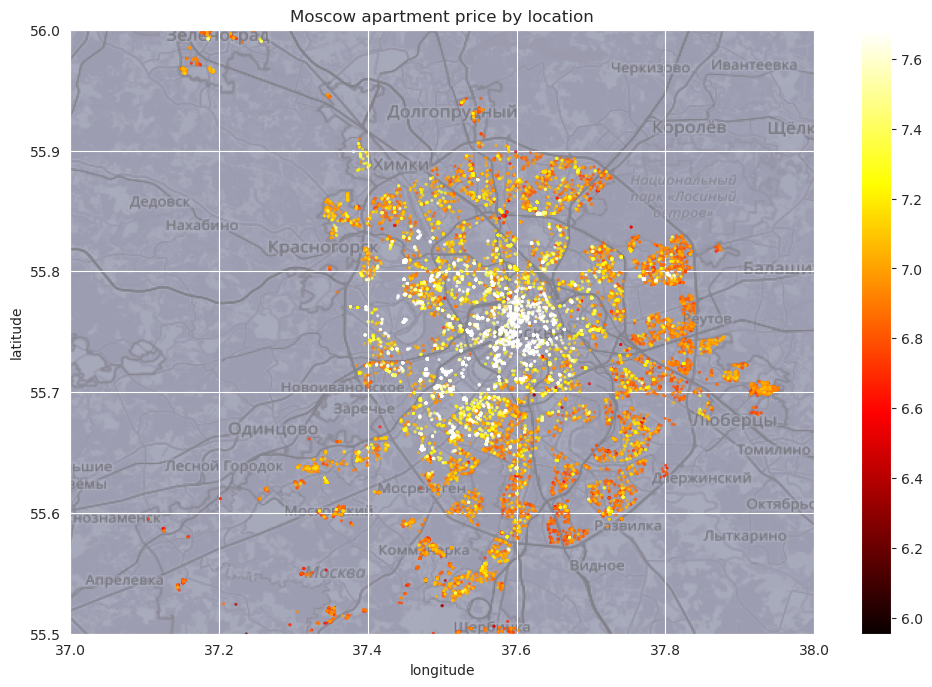

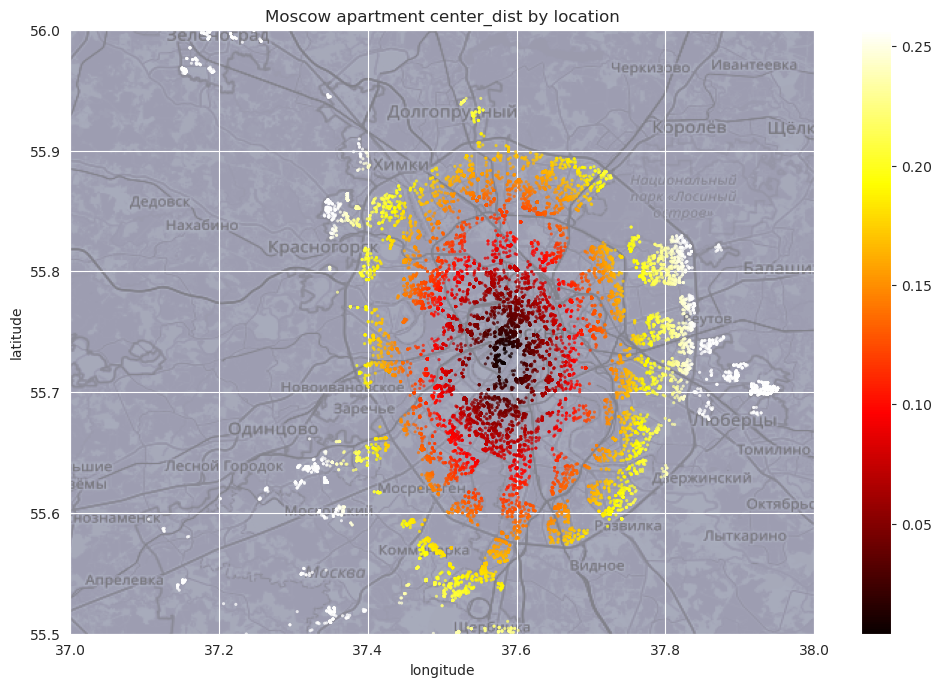

In [40]:
plot_map(data_train_log)
plot_map2(data_train_log)


## Ploting before doing the Algorithms
So now we will do some plots in order to get more clear which features are we going to use for the algorithms.

## Area_Total and price

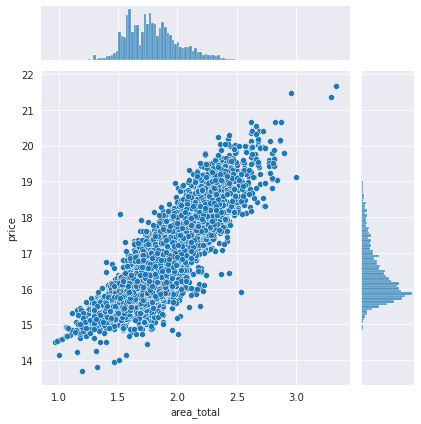

In [41]:
#We log the price
o= data_train.copy()
o['price']= np.log(data_train['price'])
g = sns.jointplot(x='area_total', y='price', data= o )

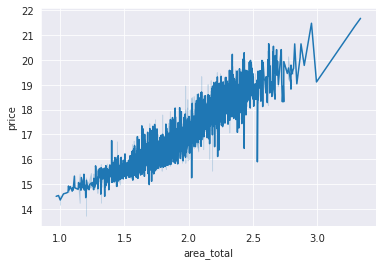

In [42]:
g = sns.lineplot(markers=True, x='area_total', y='price', data= o, )

## Phones

<AxesSubplot:xlabel='phones', ylabel='price'>

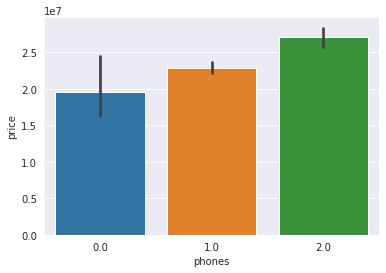

In [43]:
sns.barplot(x=data_train_filled['phones'],y=data_train_filled['price'])

## Districts

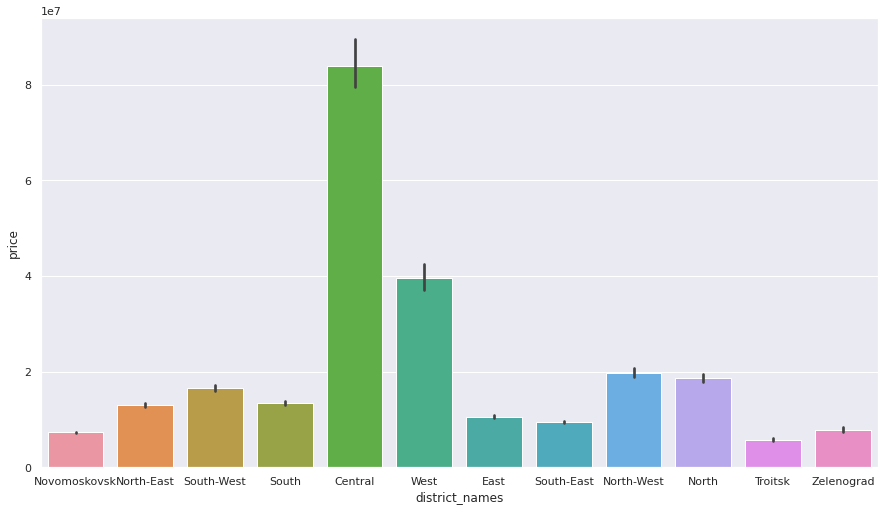

In [44]:
districts= ['Central','North','North-East', 'East', 'South-East', 'South', 'South-West', 'West', 'North-West', 'Zelenograd', 'Troitsk', 'Novomoskovsk','Missing']
districts_plot= data_train.copy()
districts_plot['district']= districts_plot['district'].fillna(12)
district_names= []
for d in range(len(districts_plot['district'])):
    district_names.append(districts[int(districts_plot.at[d,'district'])])
districts_plot['district_names']=district_names
sns.set(rc={'figure.figsize':(15,8.27)})
h=sns.barplot(x='district_names',y='price', data=districts_plot)

# Working with the dataSets
Now we will just delete the features that we don't want to use

In [45]:
#old_features = ['latitude', 'longitude','district','material','area_total','area_living', 'area_kitchen', 'rooms', 'floor', 'stories', 'parking', 'constructed', 'new', 'ceiling','bathrooms_total','bathrooms_shared', 'center_dist' ]

features_xgb = ['area_total', 'latitude', 'longitude', 'area_living', 'floor', 'ceiling', 'district', 'constructed', 'material', 'stories', 'parking', 'center_dist','seller']
features_gbr = ['area_total', 'latitude', 'longitude', 'area_kitchen', 'area_living', 'floor', 'ceiling', 'district', 'constructed', 'material', 'stories', 'parking', 'center_dist','seller']
features_lgbm = ['seller', 'area_total', 'area_kitchen', 'area_living', 'floor', 'rooms', 'condition', 'phones','new', 'latitude', 'longitude', 'district']

features_lasso = ['area_total', 'latitude', 'longitude', 'area_kitchen', 'area_living', 'floor', 'rooms', 'ceiling', 'bathrooms_shared', 'district', 'constructed', 'material', 'stories', 'parking', 'bathrooms_total', 'center_dist','seller']
features_svr = features_lasso


# Algorithms
We will work basically using this Algorithms:

    -Random forest
    -LassoLars
    -XGBoost
    -Gradient boosting
    -Ridge Regressor
    -LGBM Regressor
    -Stacking CV Regressor
Then we will blend all these models

So now we had also to decide which features would be useful for our perfomance and we chose:

    -Latitude
    -Longitude
    -District
    -Area_total
    -Area_living
    -Area_kitchen
    -Rooms
    -Bathrooms_total
    -Ceiling
    -Floor
    -Stories
    -Constructed
    -New
    -Center_dist

## Setting HyperParameters and Features for algorithms
### Features
With this code we will test all the algorithms in order to see the best features for the algorithm.
We will just have to change the estimator if we want to change the algorithm.

['seller', 'area_total', 'area_kitchen', 'area_living', 'floor', 'rooms', 'ceiling', 'bathrooms_shared', 'phones', 'latitude', 'longitude', 'district', 'constructed', 'material', 'stories', 'parking', 'bathrooms_total', 'center_dist']
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estim

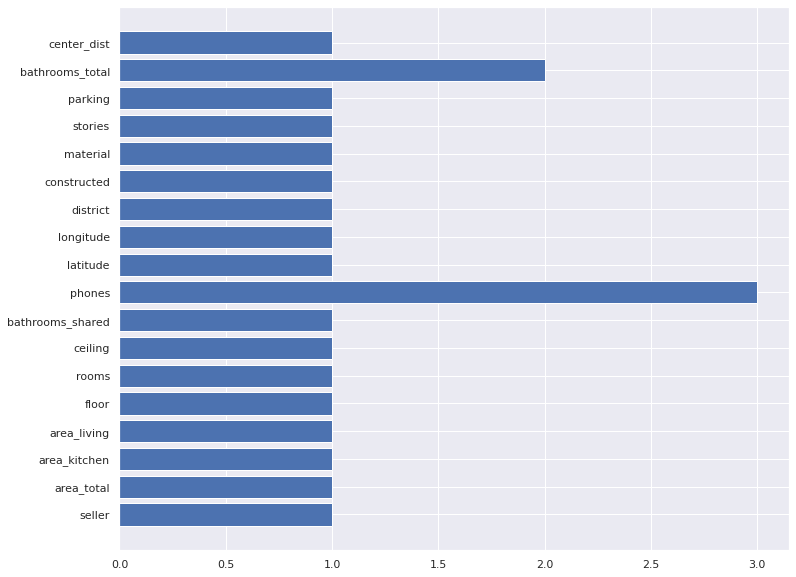

In [46]:
#Value to change in order to try different models.
from lightgbm import LGBMRegressor
from sklearn.feature_selection import RFECV

estimator = LGBMRegressor(objective='regression', num_leaves=20, learning_rate=0.1, n_estimators=2000,max_depth=10)

feats = [i for i in data_train.columns]
feats.remove('id')
feats.remove('building_id')
feats.remove('street')
feats.remove('address')
feats.remove('price')

feats.remove('elevator_passenger')
feats.remove('elevator_service')

feats.remove('loggias')
feats.remove('balconies')

feats.remove('heating')
feats.remove('windows_street')
feats.remove('windows_court')
feats.remove('layout')

feats.remove('garbage_chute')
feats.remove('new')
feats.remove('bathrooms_private')

feats.remove('condition')
feats.remove('elevator_without')

print(feats)

# Our real datasets
X_ = data_train[feats]
Y_ = np.log10(data_train['price'])
X_t = data_test[feats]


selector = RFECV(estimator, step=1, scoring='r2', min_features_to_select = 5, cv=3, verbose =2)
selector.fit(X_, Y_)

fig, ax = plt.subplots(figsize=(12,10))
ax = plt.barh(feats, selector.ranking_)


### Hyperparameters
Now that we already find our features, we will try to find the best hyperParameters to the algorithms
We can try different params changing the grid_params in every model and also we can change the model at the estimator

In [47]:
#Here it goes the LassoLarsCode example

#Here we change the grid_params to try
grid_params = {'objective':['regression'], 'num_leaves':[20,10], 'learning_rate':[0.1,0.01], 'n_estimators':[2000,20000]}
X_train1=data_train.copy()[features]

y_train1=np.log10(data_train.loc[X_train1.index].price)


# Use the random grid to search for best hyperparameters
#We can choose the model to tune here
estimator = LGBMRegressor()


#search=GridSearchCV(estimator, param_grid=grid_params, scoring='neg_mean_squared_error',n_jobs=1,cv=5)
#search.fit(X_train1, y_train1)

#print(search.best_params_)

## Setting the data for testing

In [48]:
def score_model():
    print("RMSLE SCORE RESULTS:")
    print(f'Train RMSLE: {root_mean_squared_log_error(y_true=y_train_small, y_pred=y_train_hat) :.4f}')
    print(f'Valid RMSLE: {root_mean_squared_log_error(y_true=y_test_small, y_pred=y_test_hat) :.4f}')
    print(f'Full dataset RMSLE: {root_mean_squared_log_error(y_true=y_train, y_pred=y_hat_full_training) :.4f}')

def RMSLE(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all() 
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5

Split dataset into 23285 training samples and 9937 validation samples


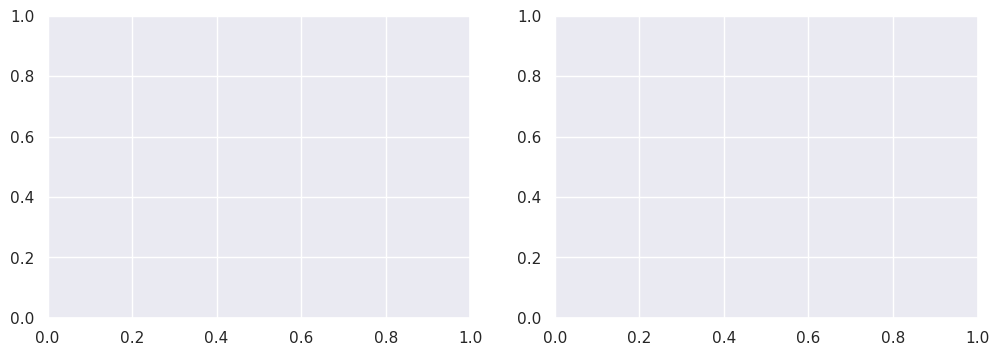

In [49]:
import sklearn.model_selection as model_selection

data_train_small, data_test_small = model_selection.train_test_split(data_train.drop('price',axis=1), test_size=0.33, stratify=np.log(data_train.price).round())
fig, (ax1, ax2) = plt.subplots(figsize=(12, 4), ncols=2, dpi=100)
print(f'Split dataset into {len(data_train)} training samples and {len(data_test)} validation samples')


## RandomForest:
RandomForest is an algorithm that works as a meta estimator, fitting a number of decision tree classifiers on various sub-samples of the dataset, then it uses averaging to improve the predictive accuracy and not doing overfitting

For this test we will use this hyperparameters:

    -n_estimators: 1000
    -max_features: 'sqrt'
    -max_depth: 50
    -min_samples_split: 2
    -min_samples_leaf: 1
    -bootstrap: True
    


### Set our features:

In [50]:
rf_features = ['area_total', 'latitude', 'longitude', 'area_kitchen', 'area_living', 'floor', 'rooms', 'ceiling', 'bathrooms_shared', 'district', 'constructed', 'material', 'stories', 'parking', 'bathrooms_total', 'center_dist','seller']

In [51]:
#here it goes the RandomForest Code
data_train_small, data_test_small = model_selection.train_test_split(data_train, test_size=0.33, stratify=np.log(data_train.price).round())

# Fit model to the dataset 
X_train = data_train_small[rf_features]
y_train = np.log10(data_train_small.loc[X_train.index].price)
X_test = data_test_small[rf_features]
y_test = np.log10(data_test_small.loc[X_test.index].price)
 
rfrmodel = RandomForestRegressor(n_estimators = 500, max_features = 'sqrt', max_depth = 35, min_samples_leaf = 1, bootstrap = True)
rfrmodel.fit(X_train,y_train)

y_test_hat = rfrmodel.predict(X_test)
y_train_hat = rfrmodel.predict(X_train)

# Now we can try the RMSLE to have an idea :
print('RMSLE train : ' + str(RMSLE(y_train,y_train_hat)))
print('RMSLE valid : ' + str(RMSLE(y_test,y_test_hat)))





RMSLE train : 0.0031663977139936043
RMSLE valid : 0.008552688838793916


Now we will create the real values for the submission part

In [52]:
# Creating the model
rfrmodel.fit(data_train[rf_features],np.log10(data_train['price']))

# Generating values
generated_values = rfrmodel.predict(X = data_test[rf_features])

# Construct submission dataframe
submission = pd.DataFrame()
submission['id'] = data_test.id
submission['price_prediction'] = 10**generated_values
submission.sort_values(by=['id'],inplace=True)

print(f'Generated {len(submission)} predictions')

# Export submission to csv with headers
submission.to_csv('randforest_submission.csv', index=False)

rfrmodel = RandomForestRegressor()

sub_rf = submission.copy()

Generated 9937 predictions


## LassoLars
LassoLars is an algorithm, that fits our data with Least Angle Regression, it is a linear model trained with an l1 prior as regularizer
For this test we will use this hyperparameters:

    -Max_iter: 1000 
    -N_jobs: 8
    -Max_n_alphas: 50
    -Cv: 100
    
Here we will try the model using just the data_train to see the RMSLE. So that we will split the data_train into data_train_small and data_test_small and then predict for the test and the train and see the score of the RMSLE

In [54]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.model_selection import KFold, cross_val_score
import sklearn.linear_model as linear_model




alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)



features = features_lasso

# Creating small datasets for research and RMSLE:
X_train_small = data_train_small[features]
y_train_small = np.log10(data_train.loc[X_train_small.index].price)

X_test_small = data_test_small[features]
y_test_small = np.log10(data_train.loc[X_test_small.index].price)

# Creating real datasets for actual predictions and submissions
X_train = data_train[features]
y_train = np.log10(data_train.loc[X_train.index].price)

X_test = data_test[features]


# Create model
start = timer()
lasso4 = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds))
lasso2 = linear_model.LassoLarsCV(max_iter=10000000)
lasso3 = Lasso(alpha=0.00001,
               max_iter=50000, 
              precompute=True, 
#              warm_start=True, 
              positive=False, 
              selection='random',
              random_state=42,
              tol=1e-4)

# Fit model to dataset
lasso.fit(X_train_small, y_train_small)
lasso2.fit(X_train_small, y_train_small)
lasso3.fit(X_train_small, y_train_small)
lasso4.fit(X_train_small, y_train_small)



# Predict training for model 1
y_train_hat = lasso.predict(X_train_small)
y_test_hat = lasso.predict(X_test_small)
y_hat_full_training = lasso.predict(X_train)

#Check score
print('Model 1 score:')
score_model()



# Predict training for model 2
y_train_hat = lasso2.predict(X_train_small)
y_test_hat = lasso2.predict(X_test_small)
y_hat_full_training = lasso2.predict(X_train)

#Check score
print('Model 2 score:')
score_model()


# Predict training for model 3
y_train_hat = lasso3.predict(X_train_small)
y_test_hat = lasso3.predict(X_test_small)
y_hat_full_training = lasso3.predict(X_train)



#Check score
print('Model 3 score:')
score_model()





# Predict training for model 4
y_train_hat = lasso4.predict(X_train_small)
y_test_hat = lasso4.predict(X_test_small)
y_hat_full_training = lasso4.predict(X_train)


#Check score
print('Model 4 score:')
score_model()


# Real prediction
# lasso.fit(X_train, y_train)
# y_hat_lasso = lasso.predict(X_test)

end = timer()
print('Time = ' + str(end - start))


Model 1 score:
RMSLE SCORE RESULTS:
Train RMSLE: 0.0156
Valid RMSLE: 0.0154
Full dataset RMSLE: 0.0156
Model 2 score:
RMSLE SCORE RESULTS:
Train RMSLE: 0.0156
Valid RMSLE: 0.0154
Full dataset RMSLE: 0.0156
Model 3 score:
RMSLE SCORE RESULTS:
Train RMSLE: 0.0156
Valid RMSLE: 0.0154
Full dataset RMSLE: 0.0156
Model 4 score:
RMSLE SCORE RESULTS:
Train RMSLE: 0.0156
Valid RMSLE: 0.0154
Full dataset RMSLE: 0.0156
Time = 0.17301837699778844


Now we will create the real values for the submission part

In [57]:
X = data_train[features]
Y = np.log10(data_train['price'])
lasso.fit(X, Y)

X_test = data_test[features]
generated_values = lasso.predict(X_test)

# Construct submission dataframe
submission = pd.DataFrame()
submission['id'] = data_test.id
submission['price_prediction'] = 10**generated_values
submission.sort_values(by=['id'],inplace=True)

print(f'Generated {len(submission)} predictions')

# Export submission to csv with headers
submission.to_csv('lassolars_submission.csv', index=False)

sub_ll = submission.copy()

Generated 9937 predictions


## XGBoost
XGBoost is an algorithm, that works as an implementation of gradient boosted decision trees, and it's designed for speed and perfomance.

For this test we will use this hyperparameters:
    
    -Learning rate: 0.05
    -N_estimators: 1200
    -Max_depth: 8
    -Min_child_weight: 0
    -Gamma: 0
    -Subsample: 0.7
    -Colsample_bytree: 0.7
    -Objective: reg:squarederror
    -Nthread: -1
    -Scale_pos_weight: 1
    -Seed: 27
    -Reg_alpha: 0.00006


### Testing

In [58]:
from sklearn import model_selection
from timeit import default_timer as timer

features = features_xgb

# Creating small datasets for research and RMSLE:
X_train_small = data_train_small[features]
y_train_small = np.log10(data_train.loc[X_train_small.index].price)

X_test_small = data_test_small[features]
y_test_small = np.log10(data_train.loc[X_test_small.index].price)

# Creating real datasets for actual predictions and submissions
X_train = data_train[features]
y_train = np.log10(data_train.loc[X_train.index].price)

X_test = data_test[features]

start = timer()

# Create model
# optimal: 0.05, 1200, 10

# Our model parametrs
xgboost = xgb.XGBRegressor(learning_rate=0.05,n_estimators=1200,
                                     max_depth=10, min_child_weight=1.0,
                                     gamma=0, subsample=0.6,
                                     colsample_bytree=0.4,
                                     objective='reg:squaredlogerror', nthread=-1,
                                     scale_pos_weight=1, seed=27,#reg_alpha=0.00006,
                                    reg_alpha=0.75, reg_lambda=0.45 )
'''
xgboost = xgb.XGBRegressor(learning_rate=0.1,n_estimators=2000,
                                     max_depth=3, min_child_weight=1.5,
                                     gamma=0, subsample=0.6,
                                     colsample_bytree=0.4,
                                     objective='reg:squaredlogerror', seed=42,
                                     reg_alpha=0.75, reg_lambda=0.45)
'''
# Fit model
xgboost.fit(X_train_small, y_train_small)

# Predict test
y_train_hat = xgboost.predict(X_train_small)
y_test_hat = xgboost.predict(X_test_small)
y_hat_full_training = xgboost.predict(X_train)

#Real prediction
xgboost.fit(X_train, y_train)
y_hat_xgb = xgboost.predict(X_test)


#Check score
score_model()

'''
#Check score
print("XGBOOST SCORE RESULTS:")
print(f'Train RMSLE: {root_mean_squared_log_error(y_true=y_train_small, y_pred=y_train_hat) :.4f}')
print(f'Valid RMSLE: {root_mean_squared_log_error(y_true=y_test_small, y_pred=y_test_hat) :.4f}')
print(f'Full dataset RMSLE: {root_mean_squared_log_error(y_true=y_train, y_pred=y_hat_full_training) :.4f}')
'''
end = timer()
print('Time = ' + str(end - start))


RMSLE SCORE RESULTS:
Train RMSLE: 0.0134
Valid RMSLE: 0.0135
Full dataset RMSLE: 0.0134
Time = 7.923087282004417


Now we will create the real values for the submission part

In [59]:
#### Submission
X_train = data_train[features]
y_train = np.log10(data_train.loc[X_train.index].price)

# We already created the model
# Fit model
xgboost.fit(X_train, y_train)

# Generate predictions for test set 
X_test = data_test[features]
y_test_hat = xgboost.predict(X_test)

# Construct submission dataframe
submission = pd.DataFrame()
submission['id'] = data_test.id
submission['price_prediction'] = 10**y_test_hat
print(f'Generated {len(submission)} predictions')

# Export submission to csv with headers
submission.to_csv('xgboost_submission.csv', index=False)

sub_xgb = submission.copy()

Generated 9937 predictions


## Gradient boosting
Gradient Boosting is an algorithm that It relies on the intuition that the best possible next model, when combined with previous models, minimizes the overall prediction error

For this test we will use this hyperparameters:

    -Learning_rate: 0.075
    -N_estimators: 800
    -Max_depth: 8


### Set our features:

In [60]:
from sklearn.ensemble import GradientBoostingRegressor

features = features_gbr

# Creating small datasets for research and RMSLE:
X_train_small = data_train_small[features]
y_train_small = np.log10(data_train.loc[X_train_small.index].price)

X_test_small = data_test_small[features]
y_test_small = np.log10(data_train.loc[X_test_small.index].price)

# Creating real datasets for actual predictions and submissions
X_train = data_train[features]
y_train = np.log10(data_train.loc[X_train.index].price)

X_test = data_test[features]


# Create model
start = timer()
gbr = GradientBoostingRegressor(n_estimators=800, learning_rate=0.03, max_depth=8, max_features='sqrt', min_samples_leaf=1, min_samples_split=10, loss='huber', random_state =42)                             

# Fit model to dataset
gbr.fit(X_train_small, y_train_small)

# Predict training
y_train_hat = gbr.predict(X_train_small)
y_test_hat = gbr.predict(X_test_small)
y_hat_full_training = gbr.predict(X_train)

#Real prediction
gbr.fit(X_train, y_train)
y_hat_gbr = gbr.predict(X_test)


#Check score
score_model()

end = timer()
print('Time = ' + str(end - start))


RMSLE SCORE RESULTS:
Train RMSLE: 0.0040
Valid RMSLE: 0.0076
Full dataset RMSLE: 0.0055
Time = 95.98949776399968


Now we will create the real values for the submission part

In [ ]:
# Creating the model
gbr.fit(data_train[features],np.log10(data_train['price']))

# Generating values
generated_values = gbr.predict(X = data_test[features])

# Construct submission dataframe
submission = pd.DataFrame()
submission['id'] = data_test.id
submission['price_prediction'] = 10**generated_values
submission.sort_values(by=['id'],inplace=True)

print(f'Generated {len(submission)} predictions')

# Export submission to csv with headers
submission.to_csv('gradient_submission.csv', index=False)

sub_grad = submission.copy()

## RidgeCVRegressor
Ridge regressor is an algorithm that uses ridge regression with built-in cross-validation.

For this test we will use this hyperparameters:

    -alphas: [1e-3, 1e-2, 1e-1, 1]

### Set our features:

In [ ]:
ridgef_features=features

In [ ]:
from sklearn import linear_model
data_train_small, data_test_small = model_selection.train_test_split(data_train, test_size=0.33, stratify=np.log(data_train.price).round())

# Fit model to the dataset 
X_train = data_train_small[ridgef_features]
y_train = np.log10(data_train_small.loc[X_train.index].price)
X_test = data_test_small[ridgef_features]
y_test = np.log10(data_test_small.loc[X_test.index].price)
 
ridgem = linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])
ridgem.fit(X_train,y_train)

y_test_hat = ridgem.predict(X_test)
y_train_hat = ridgem.predict(X_train)

# Now we can try the RMSLE to have an idea :
print('RMSLE train : ' + str(RMSLE(y_train,y_train_hat)))
print('RMSLE valid : ' + str(RMSLE(y_test,y_test_hat)))

Now we will create the real values for the submission part

In [ ]:
# Creating the model
ridgem.fit(data_train[features],np.log10(data_train['price']))

# Generating values
generated_values = ridgem.predict(X = data_test[ridgef_features])

# Construct submission dataframe
submission = pd.DataFrame()
submission['id'] = data_test.id
submission['price_prediction'] = 10**generated_values
submission.sort_values(by=['id'],inplace=True)

print(f'Generated {len(submission)} predictions')

# Export submission to csv with headers
submission.to_csv('ridge_submission.csv', index=False)

sub_ridgef = submission.copy()

## LGBM Regressor
LGBM Regressor is an algorithm that uses a gradient boosting framework that makes use of tree based learning algorithms. It is considered to be a fast processing algorithm

For this test we will use this hyperparameters:

    -Learning_rate: 0.1
    -Max_depth: 10
    -n_estimators: 2000
    -num_leaves: 10

Here we will try the model using just the data_train to see the RMSLE. So that we will split the data_train into data_train_small and data_test_small and then predict for the test and the train and see the score of the RMSLE

In [ ]:
from lightgbm import LGBMRegressor

features = features_xgb

# Creating small datasets for research and RMSLE:
X_train_small = data_train_small[features]
y_train_small = np.log10(data_train.loc[X_train_small.index].price)

X_test_small = data_test_small[features]
y_test_small = np.log10(data_train.loc[X_test_small.index].price)

# Creating real datasets for actual predictions and submissions
X_train = data_train[features]
y_train = np.log10(data_train.loc[X_train.index].price)

X_test = data_test[features]

start = timer()
# Create model
# old values: objective='regression', num_leaves=10,learning_rate=0.01, n_estimators=20000,max_bin=250, bagging_fraction=0.75,bagging_freq=5, bagging_seed=7,feature_fraction=0.2,feature_fraction_seed=7,verbose=-1,
'''
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=10,
                                       learning_rate=0.1, 
                                       n_estimators=2000,
                                       max_bin=250, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                      )
''' 
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=20, max_depth =7,
                                       learning_rate=0.03, 
                                       n_estimators=2000,
                                       #max_bin=500,
                                       #bagging_fraction=0.75,
                                       #bagging_freq=5, 
                                       #bagging_seed=7,
                                       #feature_fraction=0.2,
                                       #feature_fraction_seed=7,
                                       verbose=-1, metric= 'rmse'
                                       )

# Fit model to dataset
lightgbm.fit(X_train_small, y_train_small)

# Predict training
y_train_hat = lightgbm.predict(X_train_small)
y_test_hat = lightgbm.predict(X_test_small)
y_hat_full_training = lightgbm.predict(X_train)

#Real prediction
lightgbm.fit(X_train, y_train)
y_hat_lgbm = lightgbm.predict(X_test)


#Check score
score_model()

end = timer()
print('Time = ' + str(end - start))

Now we will create the real values for the submission part

In [ ]:
# Creating the model

lightgbm.fit(data_train[features],np.log10(data_train['price']))

# Generating values
generated_values = lightgbm.predict(X = data_test[features])

# Construct submission dataframe
submission = pd.DataFrame()
submission['id'] = data_test.id
submission['price_prediction'] = 10**generated_values
submission.sort_values(by=['id'],inplace=True)

print(f'Generated {len(submission)} predictions')

# Export submission to csv with headers
submission.to_csv('lgbm_submission.csv', index=False)

sub_lgbm = submission.copy()

## StackingCVRegressor
StackingCVRegressor  is an algortihm that uses an ensemble learning technique to combine multiple regression models via a meta-regressor.

For this test we will use this HyperParameters:
    
    -Regressors:
        ·GradientBoosting
        ·XGBoost
        ·LGBM
    -Meta_regressor: XGBoost
    -Use_features_in_secondary: True



### Set our stack estimators:

In [ ]:
from mlxtend.regressor import StackingCVRegressor
stack_gen = StackingCVRegressor(regressors=(rfrmodel, gbr, xgboost, lightgbm), meta_regressor=xgboost,use_features_in_secondary=True)

So stack algorithm needs to have the column names as f0,f1,f2.. so we just set this

In [ ]:
data_train_small, data_test_small = model_selection.train_test_split(data_train, test_size=0.33, stratify=np.log(data_train.price).round())
X_train= pd.DataFrame()
X_train['f0']=data_train_small['latitude']
X_train['f1']=data_train_small['longitude']
X_train['f2']=data_train_small['area_total']
X_train['f3']=data_train_small['stories']
X_train['f4']=data_train_small['rooms']
X_train['f5']=data_train_small['area_living']
X_train['f6']=data_train_small['area_kitchen']
X_train['f7']=data_train_small['phones']
X_train['f8']=data_train_small['district']
X_train['f9']=data_train_small['new']
X_train['f10']=data_train_small['constructed']
X_train['f11']=data_train_small['floor']
X_train['f12']=data_train_small['center_dist']
X_train['f13']=data_train_small['bathrooms_total']
X_train['f14']=data_train_small['ceiling']
X_test= pd.DataFrame()
X_test['f0']=data_test_small['latitude']
X_test['f1']=data_test_small['longitude']
X_test['f2']=data_test_small['area_total']
X_test['f3']=data_test_small['stories']
X_test['f4']=data_test_small['rooms']
X_test['f5']=data_test_small['area_living']
X_test['f6']=data_test_small['area_kitchen']
X_test['f7']=data_test_small['phones']
X_test['f8']=data_test_small['district']
X_test['f9']=data_test_small['new']
X_test['f10']=data_test_small['constructed']
X_test['f11']=data_test_small['floor']
X_test['f12']=data_test_small['center_dist']
X_test['f13']=data_test_small['bathrooms_total']
X_test['f14']=data_test_small['ceiling']


In [ ]:
y_train = np.log10(data_train_small.loc[X_train.index].price)
y_test = np.log10(data_test_small.loc[X_test.index].price)

# Create model
# Fit model
stack_gen_model=stack_gen.fit(X_train, y_train)

# Generate predictions for small_test set 
y_test_hat = stack_gen.predict(X_test)
y_train_hat = stack_gen.predict(X_train)

# Now we can try the RMSLE to have an idea :
print('RMSLE train : ' + str(RMSLE(y_train,y_train_hat)))
print('RMSLE valid : ' + str(RMSLE(y_test,y_test_hat)))

In [ ]:
X_train= pd.DataFrame()
X_train['f0']=data_train['latitude']
X_train['f1']=data_train['longitude']
X_train['f2']=data_train['area_total']
X_train['f3']=data_train['stories']
X_train['f4']=data_train['rooms']
X_train['f5']=data_train['area_living']
X_train['f6']=data_train['area_kitchen']
X_train['f7']=data_train['phones']
X_train['f8']=data_train['district']
X_train['f9']=data_train['new']
X_train['f10']=data_train['constructed']
X_train['f11']=data_train['floor']
X_train['f12']=data_train['center_dist']
X_train['f13']=data_train['bathrooms_total']
X_train['f14']=data_train['ceiling']
X_test= pd.DataFrame()
X_test['f0']=data_test['latitude']
X_test['f1']=data_test['longitude']
X_test['f2']=data_test['area_total']
X_test['f3']=data_test['stories']
X_test['f4']=data_test['rooms']
X_test['f5']=data_test['area_living']
X_test['f6']=data_test['area_kitchen']
X_test['f7']=data_test['phones']
X_test['f8']=data_test['district']
X_test['f9']=data_test['new']
X_test['f10']=data_test['constructed']
X_test['f11']=data_test['floor']
X_test['f12']=data_test['center_dist']
X_test['f13']=data_test['bathrooms_total']
X_test['f14']=data_test['ceiling']



In [ ]:
y_train = np.log10(data_train.loc[X_train.index].price)

# We already created the model
# Fit model
stack_gen_model=stack_gen.fit(X_train, y_train)

# Generate predictions for test set 
y_test_hat = stack_gen_model.predict(X_test)

# Construct submission dataframe
submission = pd.DataFrame()
submission['id'] = data_test.id
submission['price_prediction'] = 10**y_test_hat
print(f'Generated {len(submission)} predictions')

# Export submission to csv with headers
submission.to_csv('stack_submission.csv', index=False)

sub_stack = submission.copy()

## Catboost

In [ ]:
from catboost import CatBoostRegressor, Pool, cv

from lightgbm import LGBMRegressor

# CHANGE THIS
features = features_xgb

# Creating small datasets for research and RMSLE:
X_train_small = data_train_small[features]
y_train_small = np.log10(data_train.loc[X_train_small.index].price)

X_test_small = data_test_small[features]
y_test_small = np.log10(data_train.loc[X_test_small.index].price)

# Creating real datasets for actual predictions and submissions
X_train = data_train[features]
y_train = np.log10(data_train.loc[X_train.index].price)

X_test = data_test[features]


start = timer()
# Create model
catboost = CatBoostRegressor(n_estimators= 2000, learning_rate = 0.03,
                            thread_count=-1, depth=7,
                            silent= True, random_seed= 42, bagging_temperature= 0.2, loss_function = 'RMSE')


# Fit model to dataset
catboost.fit(X_train_small, y_train_small)

# Predict training
y_train_hat = catboost.predict(X_train_small)
y_test_hat = catboost.predict(X_test_small)
y_hat_full_training = catboost.predict(X_train)

# Real prediction
# catboost.fit(X_train, y_train)
# y_hat_catboost = catboost.predict(X_test)


#Check score
score_model()

end = timer()
print('Time = ' + str(end - start))


## Stacked Cross Validation

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [ ]:
# Create model
averaged_models = AveragingModels(models = (xgboost, lightgbm, catboost))

# Fit model
averaged_models.fit(X_train_small, y_train_small)

### Predict

In [ ]:
# Predict
y_train_hat = averaged_models.predict(X_train_small)
y_test_hat = averaged_models.predict(X_test_small)
y_hat_full_training = averaged_models.predict(X_train)



# Evaluate Score
print("RMSLE SCORE RESULTS:")
print(f'Train RMSLE: {root_mean_squared_log_error(y_true=y_train_small, y_pred=y_train_hat) :.4f}')
print(f'Valid RMSLE: {root_mean_squared_log_error(y_true=y_test_small, y_pred=y_test_hat) :.4f}')
print(f'Full dataset RMSLE: {root_mean_squared_log_error(y_true=y_train, y_pred=y_hat_full_training) :.4f}')

In [ ]:
#Real prediction
averaged_models.fit(X_train, y_train)
y_hat_averaged = averaged_models.predict(X_test)

# Construct submission dataframe
submission = pd.DataFrame()
submission['id'] = data_test.id
submission['price_prediction'] = 10**y_hat_averaged

#submission.loc[~X_valid_nan, 'price_prediction'] = 10**y_valid_hat # Predict on non-nan entries
#submission['price_prediction'].fillna(y_train.mean(), inplace=True) # Fill missing entries with mean predictor

print(f'Generated {len(submission)} predictions')

# Export submission to csv with headers
submission.to_csv('averaged_submission.csv', index=False)

# Look at submitted csv
print('\nLine count of submission')
!wc -l averaged_submission.csv

print('\nFirst 5 rows of submission')
!head -n 5 averaged_submission.csv


In [ ]:
# Look at submitted csv
print('\nLine count of submission')
!wc -l averaged_submission.csv

print('\nFirst 5 rows of submission')
!head -n 5 averaged_submission.csv

## Stochastic Gradient Descent

In [ ]:
from sklearn.linear_model import SGDRegressor

start = timer()

# Create model
sgd_reg = SGDRegressor( n_iter_no_change=1000)

#sgd_reg = SGDRegressor(n_iter_no_change=500, penalty=None, eta0=0.01, max_iter=100000)

# Fit model to dataset
sgd_reg.fit(X_train_small, y_train_small)

# Predict
#y_train_hat = sgd_reg.predict(X_train_small)
#y_test_hat = sgd_reg.predict(X_test_small)
#y_hat = sgd_reg.predict(X_train)

end = timer()
print('Time = ' + str(end - start))

#Check score
#score_model()


## SVR (Support Vector Regression)

In [ ]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler


features = features_svr

# Creating small datasets for research and RMSLE:
X_train_small = data_train_small[features]
y_train_small = np.log10(data_train.loc[X_train_small.index].price)

X_test_small = data_test_small[features]
y_test_small = np.log10(data_train.loc[X_test_small.index].price)

# Creating real datasets for actual predictions and submissions
X_train = data_train[features]
y_train = np.log10(data_train.loc[X_train.index].price)

X_test = data_test[features]



# Create model
start = timer()
#svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

# Fit model to dataset
svr.fit(X_train_small, y_train_small)

# Predict training
y_train_hat = svr.predict(X_train_small)
y_test_hat = svr.predict(X_test_small)
y_hat_full_training = svr.predict(X_train)


# Real prediction
# svr.fit(X_train, y_train)
# y_hat_svr = svr.predict(X_test)


#Check score
score_model()

end = timer()
print('Time = ' + str(end - start))


# Blending Models
## Blended regressors
So now that we have all the models run we will give each one some % to get a better result in the price_prediction.

We will give this %:
    
    -XGBoost:              50%
    -LGBM                  40%
    -Gradient_Boosting     10%


In [ ]:
def blend_results():
    return (((0.5) * y_hat_xgb) + \
            ((0.1) * y_hat_gbr) + \
            ((0.4) * y_hat_lgbm) )
          

y_hat_blended = blend_results()

'''
#Check Blended Score
print("Blended SCORE RESULTS:")
print(f'Full traing set RMSLE for XGB: {root_mean_squared_log_error(y_true=y_train, y_pred=y_hat_xgb) :.4f}')
print(f'Full traing set RMSLE for GBR: {root_mean_squared_log_error(y_true=y_train, y_pred=y_hat_gbr) :.4f}')
print(f'Full traing set RMSLE for LGBM: {root_mean_squared_log_error(y_true=y_train, y_pred=y_hat_lgbm) :.4f}')

print(f'Full dataset RMSLE: {root_mean_squared_log_error(y_true=y_train, y_pred=y_hat_blended) :.4f}')
'''

In [ ]:
# Construct submission dataframe
submission = pd.DataFrame()
submission['id'] = data_test.id
submission['price_prediction'] = 10**y_hat_blended

#submission.loc[~X_valid_nan, 'price_prediction'] = 10**y_valid_hat # Predict on non-nan entries
#submission['price_prediction'].fillna(y_train.mean(), inplace=True) # Fill missing entries with mean predictor

print(f'Generated {len(submission)} predictions')

# Export submission to csv with headers
submission.to_csv('blended_submission.csv', index=False)

# Look at submitted csv
print('\nLine count of submission')
!wc -l blended_submission.csv

print('\nFirst 5 rows of submission')
!head -n 5 blended_submission.csv
